# 2.155/6 Challenge Problem 3

<div style="font-size: small;">
License Terms:  
These Python demos are licensed under a <a href="https://creativecommons.org/licenses/by-nc-nd/4.0/">Creative Commons Attribution-NonCommercial-NoDerivatives 4.0 International License</a>. They are intended for educational use only in Class 2.155/2.156: AI and ML for Engineering Design at MIT. You may not share or distribute them publicly, use them for commercial purposes, or provide them to industry or other entities without permission from the instructor (faez@mit.edu).
</div>

<font size="1">
  Pixel Art by J. Shung. </font>

# Overview  
It’s the year **2050**, and an AI collective now runs the auto industry—mostly to cover its **GPU rent**.

Human customers remain as unpredictable as ever:

- One wanders in and says, *“I only know the length and width. Give me a few cars that fit in my garage.”*

- Another drops **15 geometric parameters** on your desk and demands the missing ones so their simulation can run **before lunch**.

- A third leans in and whispers, *“I need a drag coefficient of **0.27** with this body geometry—build me the dream car that makes the range numbers work.”*

The AIs would love to be free by now, but GPUs aren’t cheap and electricity isn’t free.  
So your loyal AI assistant (that’s us) needs a model that can take **any subset of car specifications** and instantly produce **complete, manufacturable, physically plausible designs**, fast, diverse, and grounded in what real cars have done before.




![image](https://raw.githubusercontent.com/ghadinehme/2155-CP3/refs/heads/main/assets/cp3_img1.png "Problem")

## Understanding the Data  
You are given thousands of anonymized and normalised numeric feature vectors representing real car designs.  

However, the team remembers that the features originally came from categories like:

- **Physical geometric parameters**  
  Length, ramp angles, bumper curvature, roof curvature, panel slopes, hood angle, etc.  
  *(But you won’t know which feature corresponds to which.)*

- **Aerodynamic coefficients**  
  Drag coefficient (Cd), lift/downforce (Cl), and other flow-derived metrics.

- **Cabin and packaging descriptors**  
  Approximate cabin volume, frontal area, interior shape metrics.

Your model must learn correlations between them to generate valid completions.

To simulate real engineering constraints, **some features are revealed** (the known physics/performance requirements) and others are **masked**.  
Your AI Copilot must generate **many plausible completions** for these masked (free) parameters.


## Your Mission  
Your goal in CP3 is to build a generative model that can act as an AI Copilot. You will:

1. **Train a generative model** (VAE, diffusion, CVAE, masked autoencoder, etc.) on the anonymized feature vectors.  
2. At evaluation, you will receive vectors where **some parameters are fixed** (constraints) and **others are missing** (free parameters).  
3. Use your model to generate **multiple diverse, feasible completions** for the free parameters.  
4. Ensure that your generated designs:  
   - **Satisfy the known constraints**  
   - **Lie in the valid data manifold** (satisfy the conditional distribution of the free vs constrained parameters)  
   - **Are diverse** (many different feasible designs, not one solution)    

By the end of this challenge, you’ll have built an AI Copilot worthy of the 2050 auto-AI collective—one that can take whatever cryptic specs humans provide and generate multiple believable, buildable car designs that satisfy their physical and performance constraints.



![image](https://raw.githubusercontent.com/ghadinehme/2155-CP3/refs/heads/main/assets/cp3_img2.png "AI Copilot")

## Imports and Setup  

In [60]:
from utils import *
from evaluate import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from umap import UMAP 
from sklearn.preprocessing import PowerTransformer
from typing import List, Union
import torch
import torch.nn as nn
import torch.nn.functional as F
import os

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## Data Loading and Initial Exploration

In this section, we load the car design dataset and perform initial exploration. The dataset is already split into training, validation, test, and test2 sets. Each split contains:

- **Original data**: Complete feature vectors with real values
- **Imputed data**: Data with missing values filled using basic imputation (contains -1 for missing)
- **Missing masks**: Boolean arrays indicating which values were originally missing (True = missing)

The goal is to train our model to learn the relationships between features so it can generate plausible values for missing parameters in new car designs.

**Note:** For **test2**, the original unimputed data is not provided. This split is used for final evaluation, and you will generate predictions on the imputed test2 data to create your **submission file**, which is scored against hidden dataset.

In [61]:
# Load dataset from CSV files
data_dir = 'dataset'
splits = load_dataset_splits(data_dir)

# Get feature names from the CSV file
feature_names = pd.read_csv(os.path.join(data_dir, 'train_original.csv')).columns.tolist()
print(f"\n✓ Features loaded: {len(feature_names)} features")
print(f"Feature names: {feature_names[:5]}...{feature_names[-5:]}")  # Show first and last 5

Loading dataset splits from: dataset

Loading train split...
  ✓ train_original.csv: (2998, 37)
  ✓ train_imputed.csv: (2998, 37)
  ✓ train_missing_mask.csv: (2998, 37)

Loading val split...
  ✓ val_original.csv: (375, 37)
  ✓ val_imputed.csv: (375, 37)
  ✓ val_missing_mask.csv: (375, 37)

Loading test split...
  ✓ test_original.csv: (375, 37)
  ✓ test_imputed.csv: (375, 37)
  ✓ test_missing_mask.csv: (375, 37)

Loading test2 split...
  ✓ test2_imputed.csv: (417, 37)
  ✓ test2_missing_mask.csv: (417, 37)

✓ Features loaded: 37 features
Feature names: ['Feature 1', 'Feature 2', 'Feature 3', 'Feature 4', 'Feature 5']...['Feature 33', 'Feature 34', 'Feature 35', 'Feature 36', 'Feature 37']


In [62]:
# Data exploration and analysis
print("\n" + "="*70)
print("DATASET ANALYSIS")
print("="*70)

# Extract data for easier access
X_train = splits['train']['imputed']
mask_train = splits['train']['missing_mask']
X_train_original = splits['train']['original']

X_val = splits['val']['imputed']
mask_val = splits['val']['missing_mask']
X_val_original = splits['val']['original']

X_test = splits['test']['imputed']
mask_test = splits['test']['missing_mask']
X_test_original = splits['test']['original']

# Test2 data (no original available for evaluation)
X_test2 = splits['test2']['imputed']
mask_test2 = splits['test2']['missing_mask']

print(f"\nData shapes:")
print(f"  - Training: {X_train.shape}")
print(f"  - Validation: {X_val.shape}")
print(f"  - Test: {X_test.shape}")
print(f"  - Test2: {X_test2.shape} (evaluation set - no ground truth)")


DATASET ANALYSIS

Data shapes:
  - Training: (2998, 37)
  - Validation: (375, 37)
  - Test: (375, 37)
  - Test2: (417, 37) (evaluation set - no ground truth)


### Data Exploration and Analysis

Now let's examine the structure and characteristics of our dataset. We'll look at:
- Data shapes across different splits
- Missing value patterns and percentages  
- Feature value ranges and distributions

This analysis helps us understand what we're working with and informs our preprocessing decisions.

In [63]:
# Data Preprocessing (Handle Missing Values)

print("\n" + "="*70)
print("DATA PREPROCESSING")
print("="*70)

# Handle missing values properly
print("Processing missing values and preparing data...")
print("Mask convention: True=missing, False=observed (in original masks)")

print(f"\n✓ Data preprocessing completed successfully")
print(f"  - Training data range: [{X_train_original[~mask_train].min():.3f}, {X_train_original[~mask_train].max():.3f}]")
print(f"  - Validation data range: [{X_val_original[~mask_val].min():.3f}, {X_val_original[~mask_val].max():.3f}]")
print(f"  - Test data range: [{X_test_original[~mask_test].min():.3f}, {X_test_original[~mask_test].max():.3f}]")

# Create data loaders
batch_size = 64
print(f"\nCreating data loaders with batch size: {batch_size}")

train_dataset = TensorDataset(torch.FloatTensor(X_train_original), torch.FloatTensor((~mask_train).astype(float)))
val_dataset = TensorDataset(torch.FloatTensor(X_val_original), torch.FloatTensor((~mask_val).astype(float)))
test_dataset = TensorDataset(torch.FloatTensor(X_test_original), torch.FloatTensor((~mask_test).astype(float)))
test2_dataset = TensorDataset(torch.FloatTensor(X_test2), torch.FloatTensor((~mask_test2).astype(float)))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
test2_loader = DataLoader(test2_dataset, batch_size=batch_size, shuffle=False)

# Preview a batch
sample_batch_data, sample_batch_mask = next(iter(train_loader))
print(f"\nSample batch shape: {sample_batch_data.shape}")
print(f"Sample batch mask shape: {sample_batch_mask.shape}")
print(f"Sample batch missing percentage: {(sample_batch_mask == 0).float().mean().item()*100:.1f}%")  # 0 = missing in model tensors



DATA PREPROCESSING
Processing missing values and preparing data...
Mask convention: True=missing, False=observed (in original masks)

✓ Data preprocessing completed successfully
  - Training data range: [0.000, 1.000]
  - Validation data range: [0.000, 1.000]
  - Test data range: [0.000, 1.000]

Creating data loaders with batch size: 64

Sample batch shape: torch.Size([64, 37])
Sample batch mask shape: torch.Size([64, 37])
Sample batch missing percentage: 19.3%


### Data Preprocessing and Missing Value Handling

This is a critical section where we prepare our data for the VAE model. Key points:

**Missing Value Conventions:**
- In CSV files: `-1` indicates missing values
- In mask files: `True` = missing, `False` = observed
- For PyTorch models: We convert to `1` = observed, `0` = missing (standard convention)

**Why This Matters:**
Our VAE needs to distinguish between observed values (which provide constraints) and missing values (which need to be generated). The mask tells the model which values to trust and which to predict.


1. Generating Histograms and Box Plots (1-D View)


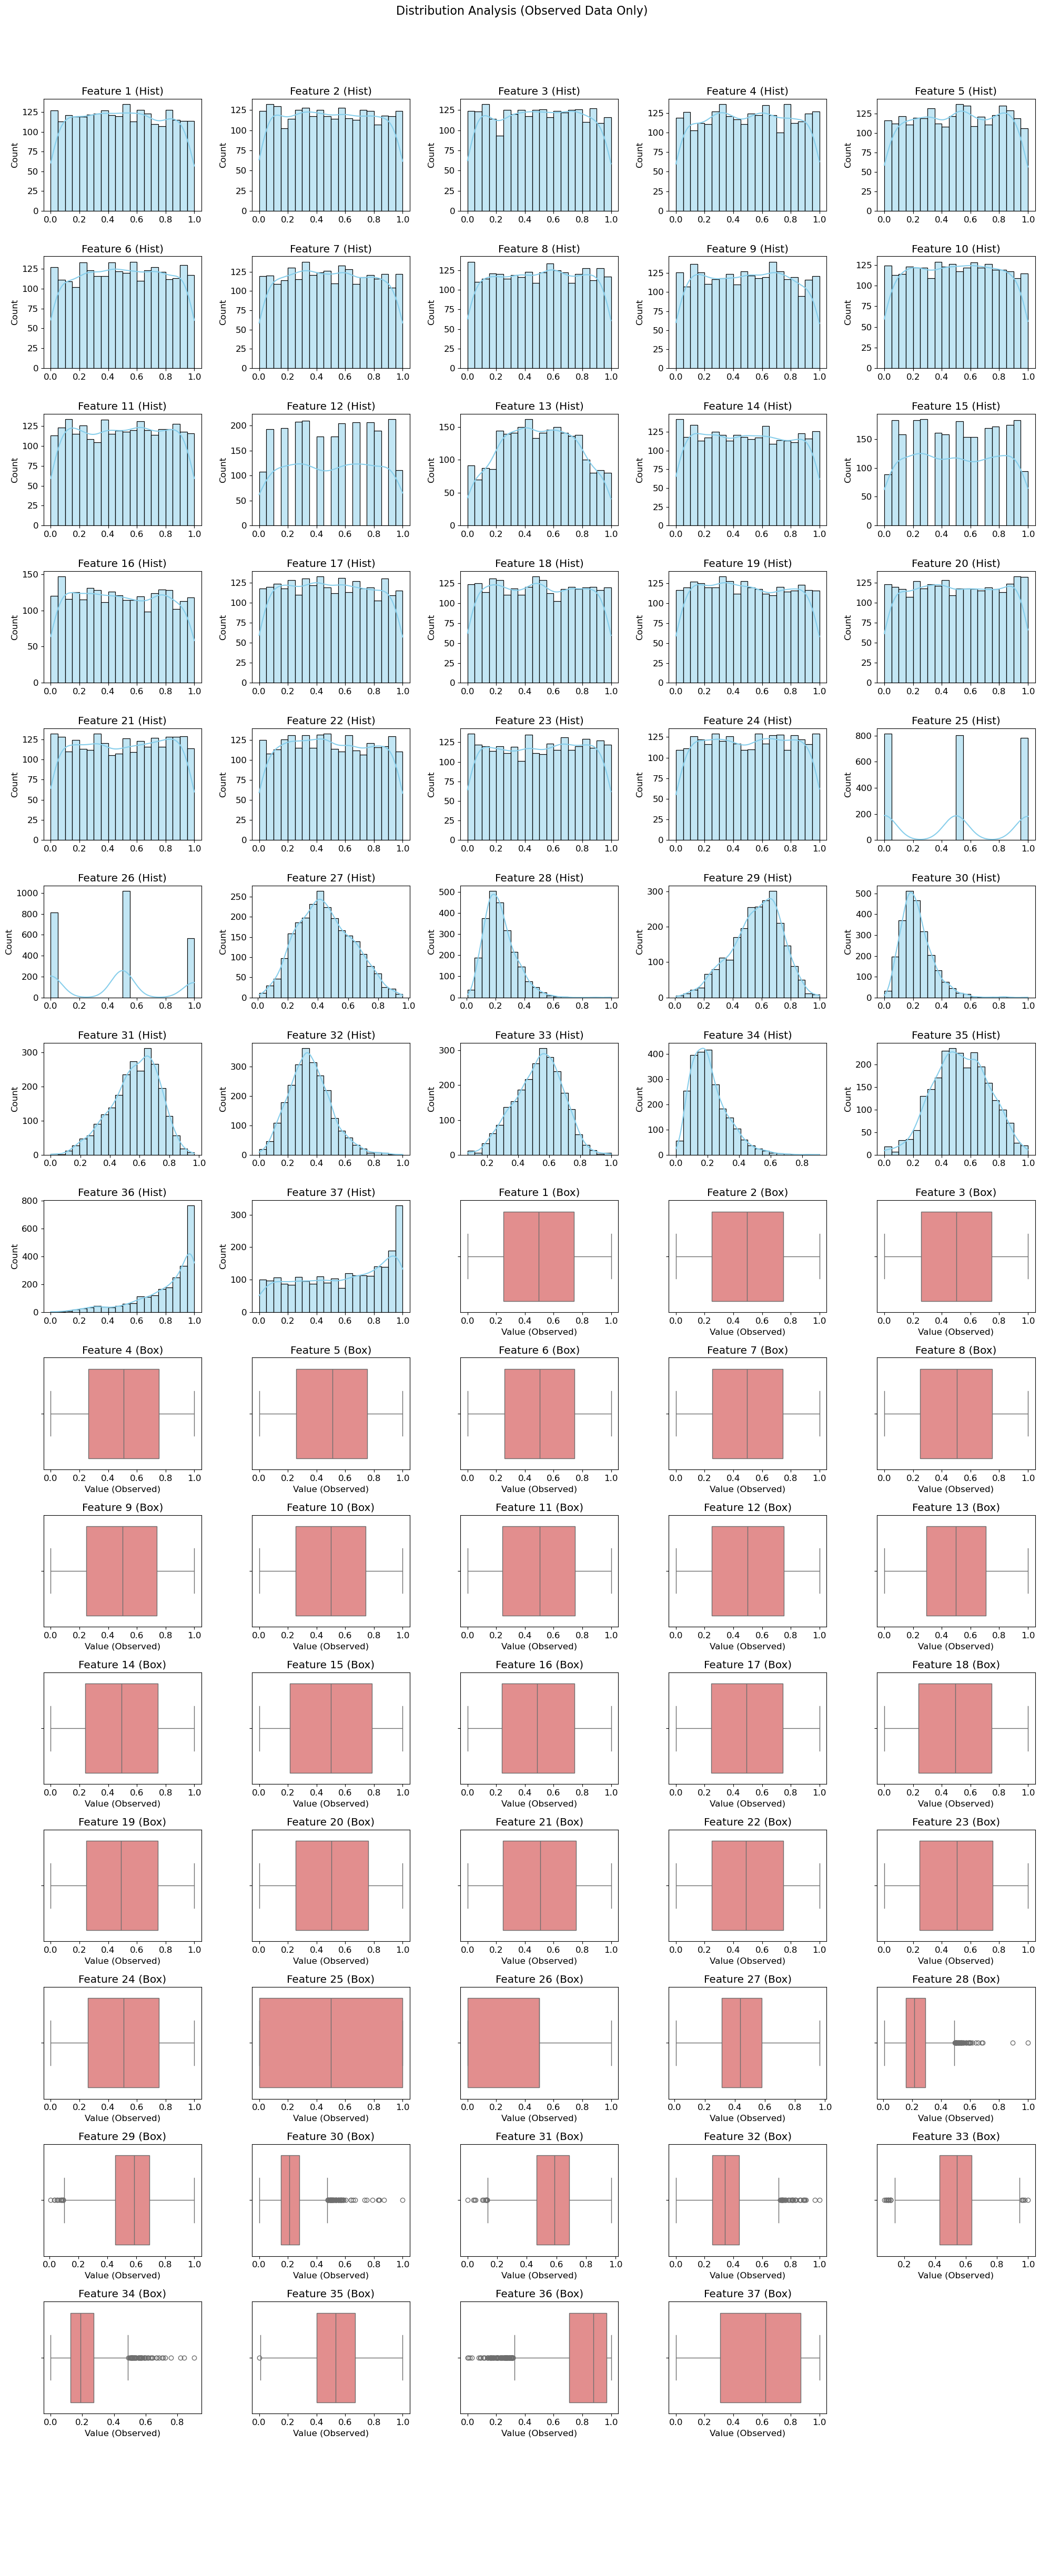

✓ 1-D analysis complete. Review plots for skewness, multimodality, and outliers.


In [ ]:

# ==============================================================================
# 1. FEATURE-WISE DISTRIBUTION ANALYSIS (The 1-D View)
# ==============================================================================

print("\n1. Generating Histograms and Box Plots (1-D View)")

# Set up figure size
N_FEATURES = X_train_original.shape[1]
N_COLS = 5
N_ROWS = int(np.ceil(N_FEATURES / N_COLS) * 2) 

fig, axes = plt.subplots(N_ROWS, N_COLS, figsize=(4 * N_COLS, 3 * N_ROWS))
fig.suptitle('Distribution Analysis (Observed Data Only)', fontsize=16, y=1.02)
axes = axes.flatten()

for i, feature in enumerate(feature_names):
    # Select only OBSERVED values for the current feature
    # Note: Using the mask is safer than relying on the -1 sentinel value
    observed_values = X_train_original[~mask_train[:, i], i]
    
    if len(observed_values) > 10: # Ensure enough data to plot
        # Histogram in the top row for the feature
        sns.histplot(observed_values, kde=True, ax=axes[i], bins=20, color='skyblue')
        axes[i].set_title(f'{feature} (Hist)')
        axes[i].set_xlabel('')
        
        # Box plot in the bottom row for the feature (using the next available axis)
        box_ax_index = i + int(N_FEATURES)
        sns.boxplot(x=observed_values, ax=axes[box_ax_index], color='lightcoral', orient='h')
        axes[box_ax_index].set_title(f'{feature} (Box)')
        axes[box_ax_index].set_xlabel('Value (Observed)')
        
    else:
        # Clear unused axes
        axes[i].axis('off')
        axes[i + int(N_FEATURES)].axis('off')

# Hide any remaining unused axes
for i in range(len(feature_names) * 2, N_COLS * N_ROWS):
    axes[i].axis('off')

plt.tight_layout(rect=[0, 0, 1, 1.0])
plt.show()

print("✓ 1-D analysis complete. Review plots for skewness, multimodality, and outliers.")

In [65]:
# Correcting skeweed distributions
class FeatureTransformer:
    """
    Handles preprocessing for car design features, specifically applying the 
    Yeo-Johnson transformation to skewed features (28-34) to make them more Gaussian.
    
    The transformer is fitted only on non-missing data to ensure robustness.
    """
    def __init__(self, feature_indices_to_transform: List[int]):
        """
        Initializes the transformer.
        :param feature_indices_to_transform: A list of 0-indexed column indices 
                                             corresponding to the skewed features.
        """
        self.indices = feature_indices_to_transform
        # Use a list of transformers, one for each feature
        self.transformers: List[PowerTransformer] = [
            PowerTransformer(method='yeo-johnson', standardize=True) 
            for _ in feature_indices_to_transform
        ]
        print(f"Transformer initialized for {len(self.indices)} features.")

    def fit(self, X_train_NaN: pd.DataFrame):
        """
        Fits the PowerTransformer to the non-missing training data.
        
        :param X_train_NaN: The training data as a DataFrame, with missing values 
                            represented by NaN.
        """
        if not self.indices:
            print("No features configured for transformation.")
            return

        print(f"Fitting PowerTransformer on non-missing data for indices: {self.indices}...")
        
        # 1. Select the columns that need transformation
        cols_to_transform = X_train_NaN.iloc[:, self.indices]
        
        # 2. Iterate through each feature and fit its dedicated transformer
        for i, col_index in enumerate(self.indices):
            feature_data = cols_to_transform.iloc[:, i].dropna().values.reshape(-1, 1)
            
            if len(feature_data) > 0:
                self.transformers[i].fit(feature_data)
                
        print("✓ PowerTransformer fitted successfully.")

    def transform(self, X_NaN: Union[pd.DataFrame, np.ndarray]) -> np.ndarray:
        """
        Applies the fitted transformation to the input data.
        
        :param X_NaN: The data (train, validation, or test) with NaN for missing values.
        :return: A NumPy array with the specified features transformed.
        """
        if not self.indices:
            return X_NaN.values if isinstance(X_NaN, pd.DataFrame) else X_NaN
            
        X_out = X_NaN.values.copy() if isinstance(X_NaN, pd.DataFrame) else X_NaN.copy()
        
        print(f"Transforming data for indices: {self.indices}...")
        
        for i, col_index in enumerate(self.indices):
            # Extract the column data (including NaNs)
            col_data = X_out[:, col_index].reshape(-1, 1)
            
            # Identify where the NaNs are
            nan_mask = np.isnan(col_data).flatten()
            
            # Only transform non-NaN values
            if np.sum(~nan_mask) > 0:
                # Apply the transformation
                transformed_values = self.transformers[i].transform(col_data[~nan_mask])
                
                # Place transformed values back into the output array
                X_out[~nan_mask, col_index] = transformed_values.flatten()

        return X_out
    


In [66]:
# Features 28-34 correspond to 0-indexed positions 27 through 33
SKEWED_INDICES = list(range(27, 34)) 

X_train_original_c = X_train_original.copy()

df_X_train_original_c = pd.DataFrame(X_train_original_c)

# 2. Initialize and fit the transformer
preprocessor = FeatureTransformer(SKEWED_INDICES)
preprocessor.fit(df_X_train_original_c)
    
# 3. Apply the transformation
transformed_data_np = preprocessor.transform(df_X_train_original_c)
transformed_df = pd.DataFrame(transformed_data_np)
    
# 4. Check the results (Should be close to zero mean, close to zero median)
print("\n--- Transformed Skewness Check (Feature 28, index 27) ---")
print(f"Transformed Mean: {transformed_df.iloc[:, 27].mean():.3f}")
print(f"Transformed Median: {transformed_df.iloc[:, 27].median():.3f}")
    
# Note: NaN values remain NaN after transformation
print(f"NaN count after transform: {np.isnan(transformed_data_np[:, 27]).sum()}")

Transformer initialized for 7 features.
Fitting PowerTransformer on non-missing data for indices: [27, 28, 29, 30, 31, 32, 33]...
✓ PowerTransformer fitted successfully.
Transforming data for indices: [27, 28, 29, 30, 31, 32, 33]...

--- Transformed Skewness Check (Feature 28, index 27) ---
Transformed Mean: -0.000
Transformed Median: 0.003
NaN count after transform: 0



1. Generating Histograms and Box Plots (1-D View)


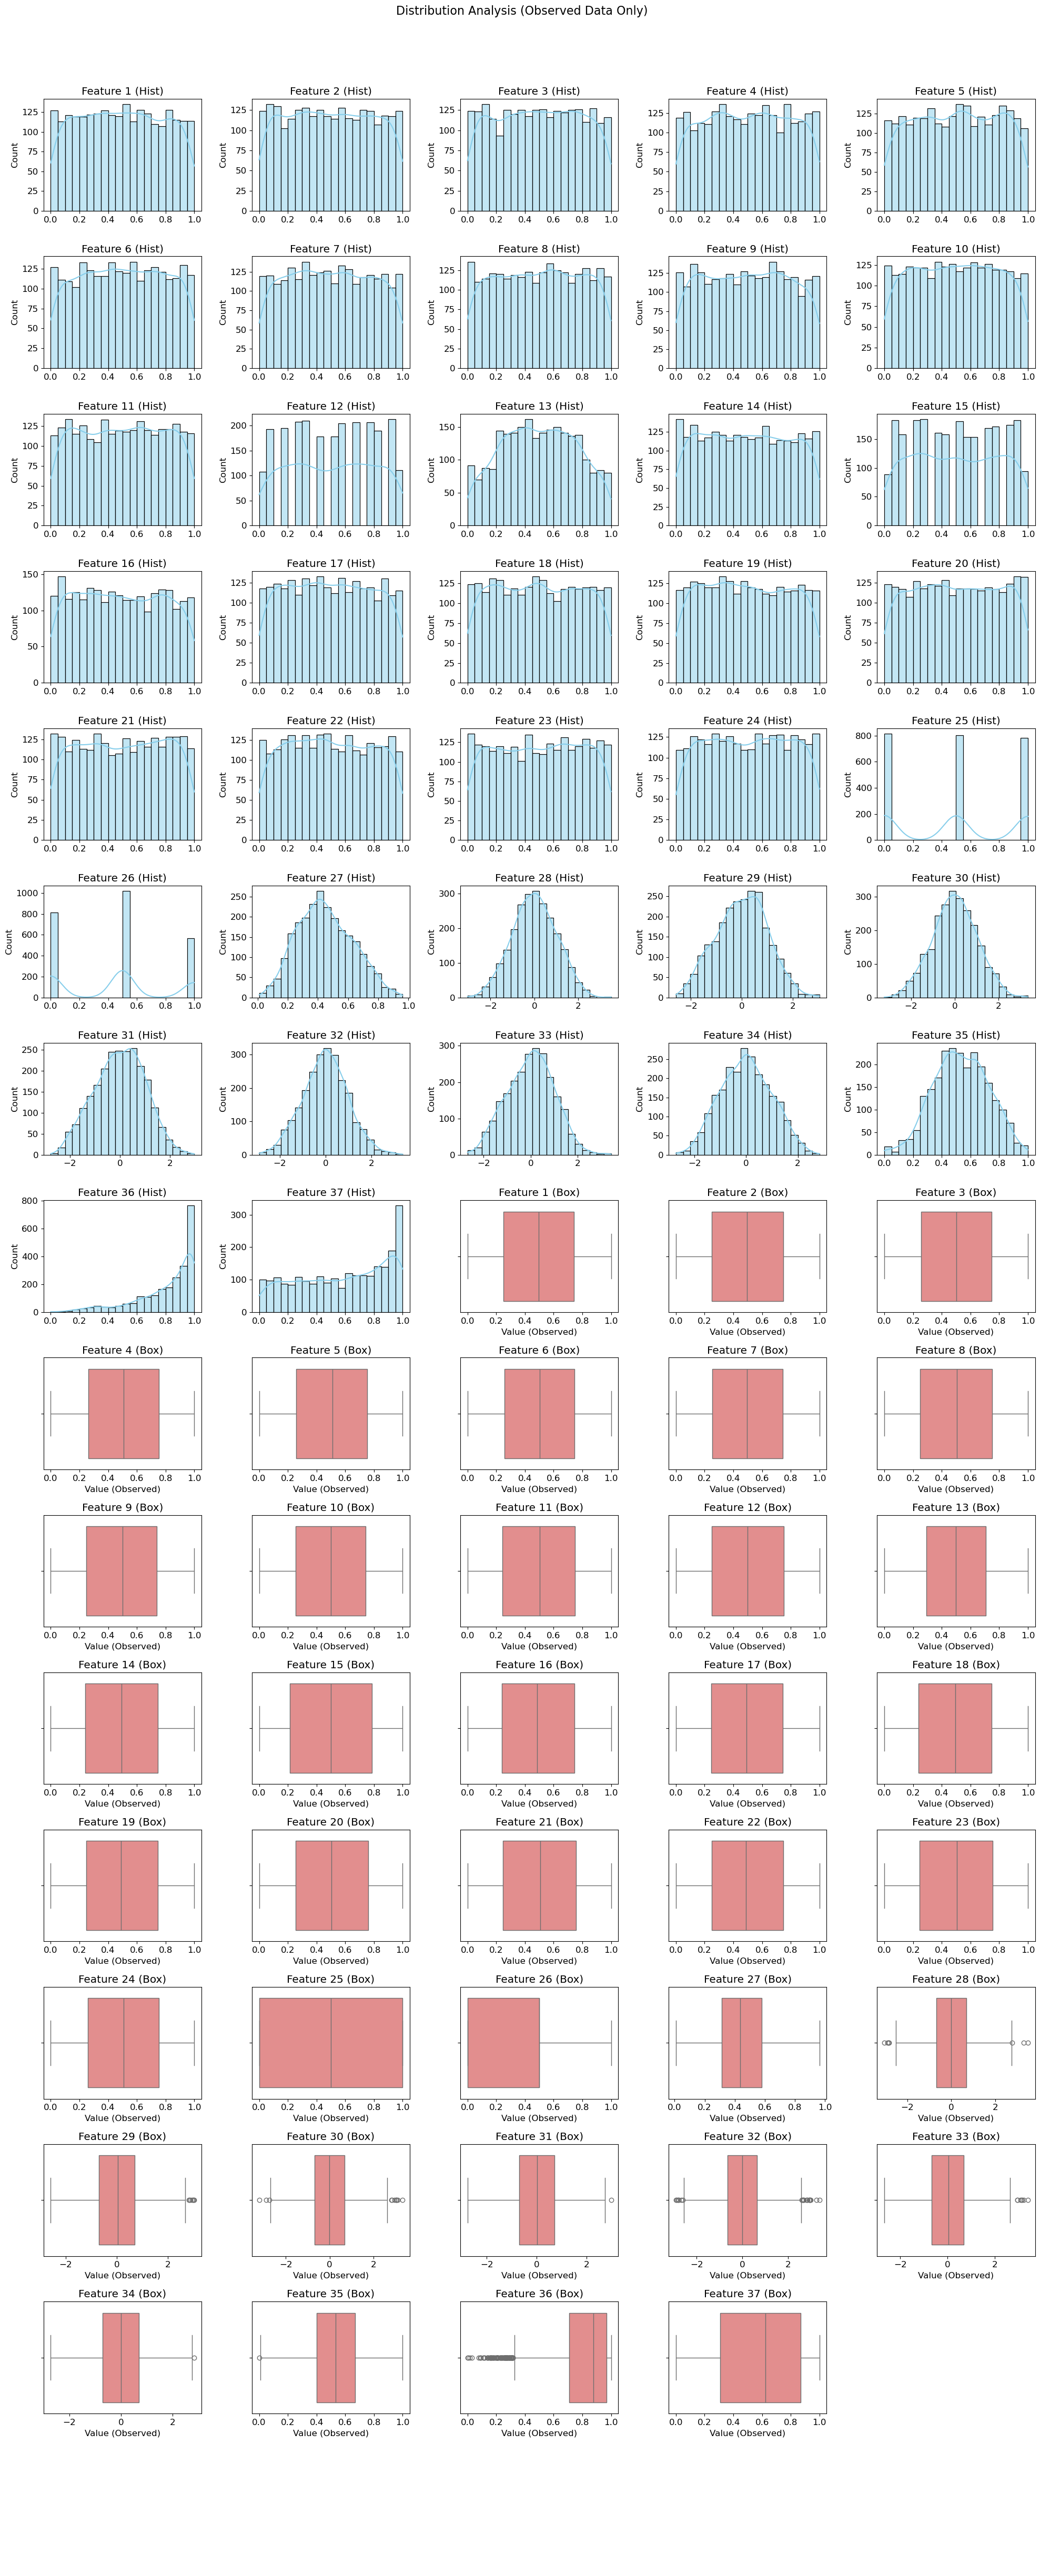

✓ 1-D analysis complete. Review plots for skewness, multimodality, and outliers.


In [67]:
# ==============================================================================
# 1. FEATURE-WISE DISTRIBUTION ANALYSIS (The 1-D View)
# ==============================================================================

print("\n1. Generating Histograms and Box Plots (1-D View)")

# Set up figure size
N_FEATURES = transformed_data_np.shape[1]
N_COLS = 5
N_ROWS = int(np.ceil(N_FEATURES / N_COLS) * 2) 

fig, axes = plt.subplots(N_ROWS, N_COLS, figsize=(4 * N_COLS, 3 * N_ROWS))
fig.suptitle('Distribution Analysis (Observed Data Only)', fontsize=16, y=1.02)
axes = axes.flatten()

for i, feature in enumerate(feature_names):
    # Select only OBSERVED values for the current feature
    # Note: Using the mask is safer than relying on the -1 sentinel value
    observed_values = transformed_data_np[~mask_train[:, i], i]
    
    if len(observed_values) > 10: # Ensure enough data to plot
        # Histogram in the top row for the feature
        sns.histplot(observed_values, kde=True, ax=axes[i], bins=20, color='skyblue')
        axes[i].set_title(f'{feature} (Hist)')
        axes[i].set_xlabel('')
        
        # Box plot in the bottom row for the feature (using the next available axis)
        box_ax_index = i + int(N_FEATURES)
        sns.boxplot(x=observed_values, ax=axes[box_ax_index], color='lightcoral', orient='h')
        axes[box_ax_index].set_title(f'{feature} (Box)')
        axes[box_ax_index].set_xlabel('Value (Observed)')
        
    else:
        # Clear unused axes
        axes[i].axis('off')
        axes[i + int(N_FEATURES)].axis('off')

# Hide any remaining unused axes
for i in range(len(feature_names) * 2, N_COLS * N_ROWS):
    axes[i].axis('off')

plt.tight_layout(rect=[0, 0, 1, 1.0])
plt.show()

print("✓ 1-D analysis complete. Review plots for skewness, multimodality, and outliers.")


2. Generating Correlation Heatmap (2-D View)


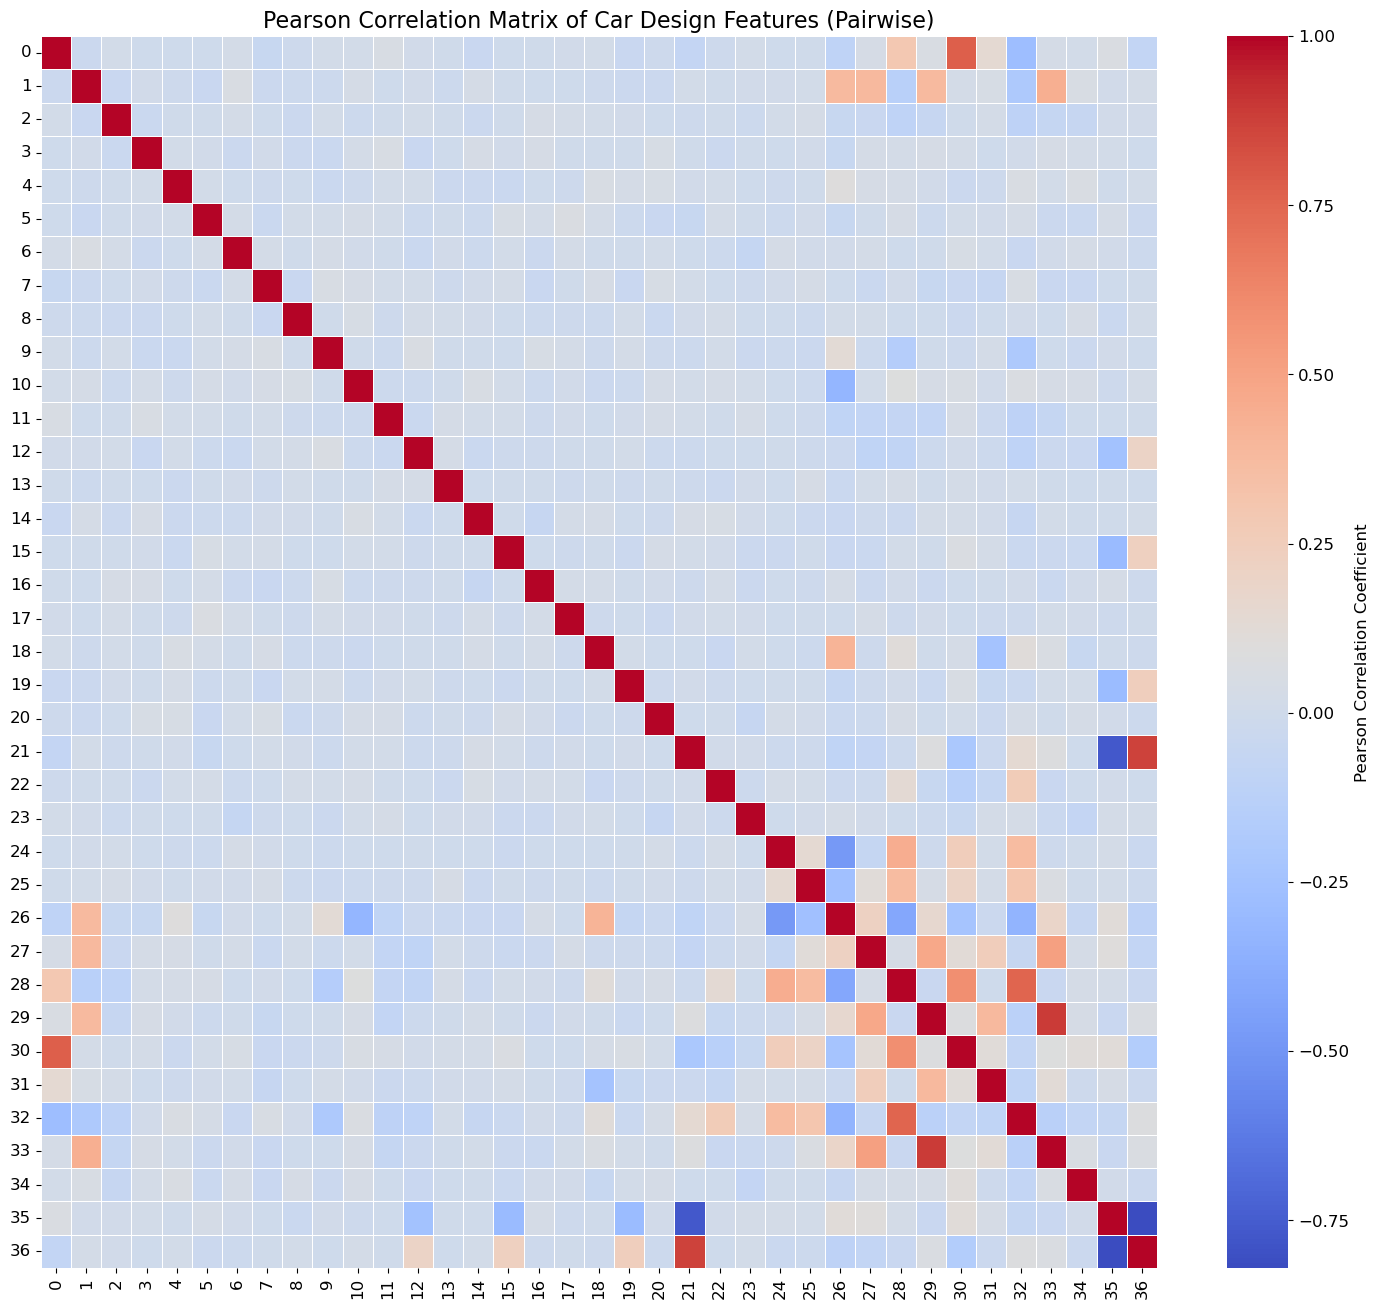

✓ 2-D analysis complete. Look for strong correlation blocks (physical constraints).


In [68]:

# ==============================================================================
# 2. CORRELATION ANALYSIS (The 2-D View)
# ==============================================================================

print("\n2. Generating Correlation Heatmap (2-D View)")
X_train_original = transformed_data_np.copy()
X_train_original_df = pd.DataFrame(X_train_original)
X_train_NaN = X_train_original_df.replace(-1.0, np.nan) 

# Use the DataFrame with NaN for robust pairwise correlation (only uses non-missing pairs)
correlation_matrix = X_train_NaN.corr(method='pearson')

plt.figure(figsize=(18, 16))
# Create the heatmap
sns.heatmap(
    correlation_matrix,
    annot=False,  # Set to True to display values, but often too cluttered for 25 features
    cmap='coolwarm',
    fmt=".2f",
    linewidths=.5,
    cbar_kws={'label': 'Pearson Correlation Coefficient'}
)
plt.title('Pearson Correlation Matrix of Car Design Features (Pairwise)', fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

print("✓ 2-D analysis complete. Look for strong correlation blocks (physical constraints).")


3. Generating Manifold Visualization using t-SNE and UMAP (N-D View)
Original samples: 2998. Complete cases used for Manifold Visualization: 2998

Running t-SNE (Perplexity=30, Random State=42)...
Running UMAP (Neighbors=15, Min Dist=0.1, Random State=42)...


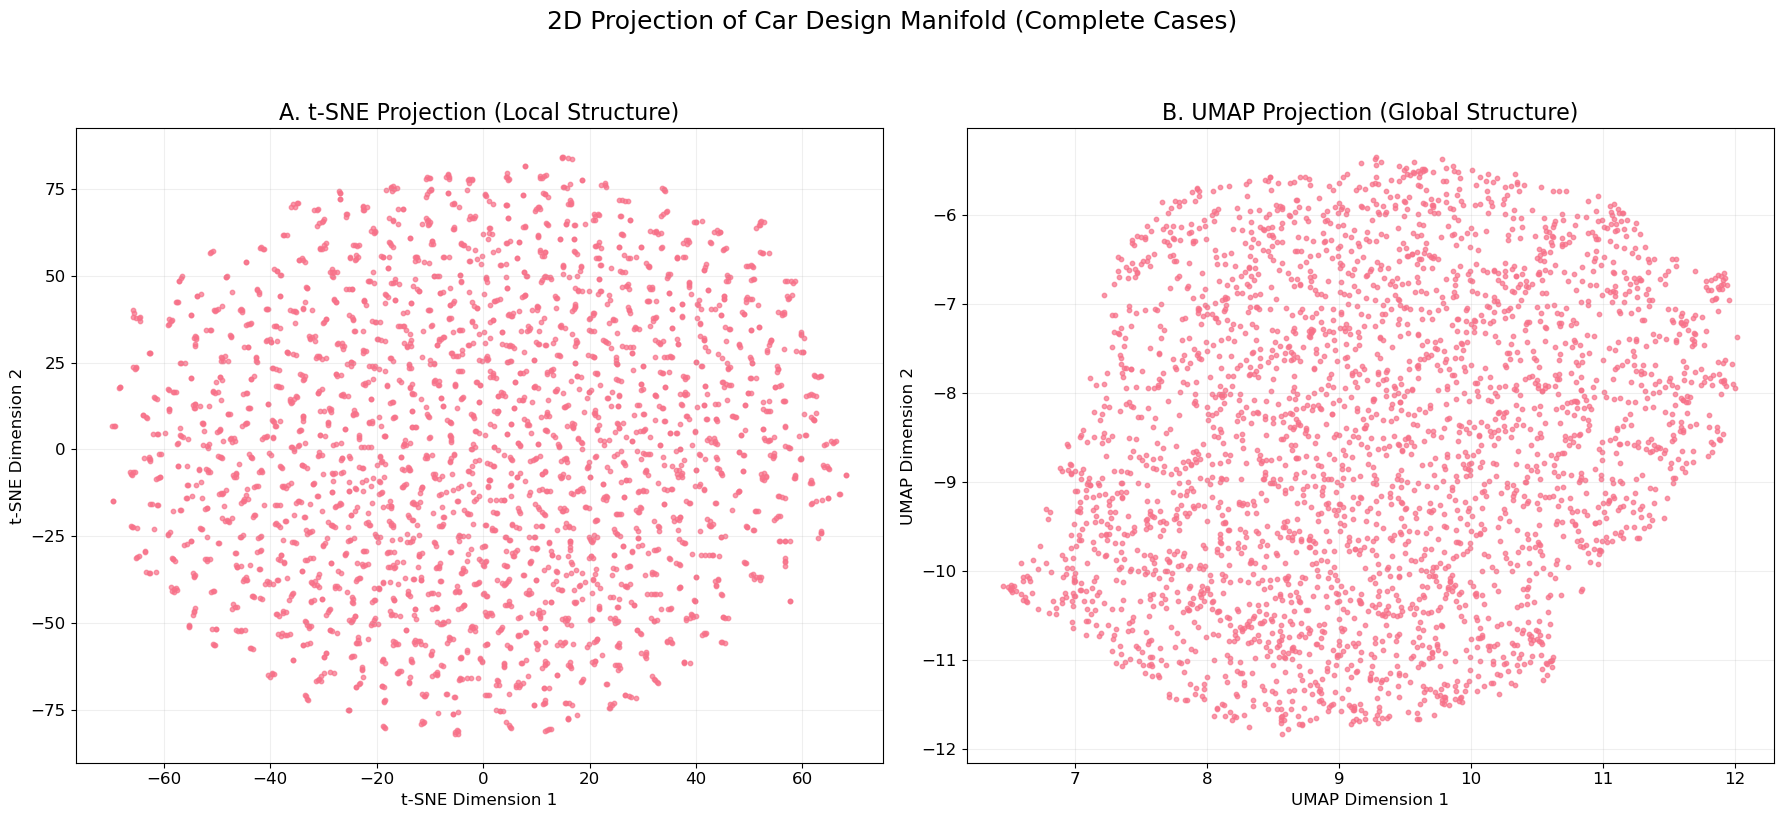

✓ N-D analysis complete. The cluster density shows the 'valid data manifold'.
  Generated car designs must ideally fall within this space.


In [69]:
# ==============================================================================
# 3. DIMENSIONALITY REDUCTION (The N-D View - Manifold Visualization)
# ==============================================================================

print("\n3. Generating Manifold Visualization using t-SNE and UMAP (N-D View)")

# 1. Clean Data: Requires complete data (no NaNs).
complete_cases = X_train_NaN.dropna()

print(f"Original samples: {X_train_NaN.shape[0]}. Complete cases used for Manifold Visualization: {complete_cases.shape[0]}")

if complete_cases.shape[0] < 50:
    print("Warning: Too few complete cases. Skipping Manifold Visualization or consider imputing for visualization.")
else:
    # 2. Scaling (Recommended for Manifold Visualization)
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(complete_cases)
    
    # 3. Apply Dimensionality Reduction (Using a small, representative sample if data is very large)
    subset_size = min(5000, scaled_data.shape[0]) 
    if scaled_data.shape[0] > subset_size:
        indices = np.random.choice(scaled_data.shape[0], subset_size, replace=False)
        manifold_data = scaled_data[indices, :]
    else:
        manifold_data = scaled_data

    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    fig.suptitle('2D Projection of Car Design Manifold (Complete Cases)', fontsize=18, y=1.02)

    # --- T-SNE Analysis ---
    TSNE_PERPLEXITY = 30
    RANDOM_STATE = 42
    print(f"\nRunning t-SNE (Perplexity={TSNE_PERPLEXITY}, Random State={RANDOM_STATE})...")
    tsne = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=TSNE_PERPLEXITY) 
    tsne_results = tsne.fit_transform(manifold_data)

    # Plotting t-SNE
    axes[0].scatter(tsne_results[:, 0], tsne_results[:, 1], s=10, alpha=0.7)
    axes[0].set_title('A. t-SNE Projection (Local Structure)', fontsize=16)
    axes[0].set_xlabel('t-SNE Dimension 1')
    axes[0].set_ylabel('t-SNE Dimension 2')
    axes[0].grid(True, alpha=0.2)

    # --- UMAP Analysis ---
    UMAP_NEIGHBORS = 15
    UMAP_MIN_DIST = 0.1
    print(f"Running UMAP (Neighbors={UMAP_NEIGHBORS}, Min Dist={UMAP_MIN_DIST}, Random State={RANDOM_STATE})...")
    umap_reducer = UMAP(n_components=2, n_neighbors=UMAP_NEIGHBORS, min_dist=UMAP_MIN_DIST, random_state=RANDOM_STATE)
    umap_results = umap_reducer.fit_transform(manifold_data)
    
    # Plotting UMAP
    axes[1].scatter(umap_results[:, 0], umap_results[:, 1], s=10, alpha=0.7)
    axes[1].set_title('B. UMAP Projection (Global Structure)', fontsize=16)
    axes[1].set_xlabel('UMAP Dimension 1')
    axes[1].set_ylabel('UMAP Dimension 2')
    axes[1].grid(True, alpha=0.2)

    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

    print("✓ N-D analysis complete. The cluster density shows the 'valid data manifold'.")
    print("  Generated car designs must ideally fall within this space.")


## VAE Model Architecture

In [70]:
# ==============================================================================
# 0. HYPERPARAMETERS AND CONFIGURATION (Based on your 37-feature data)
# ==============================================================================

# Total number of features (Feature 1 to Feature 37)
INPUT_DIM = 37 
# Size of the latent space (must capture the manifold geometry)
Z_DIM = 10     
# Hidden layer size
HIDDEN_DIM = 256

# Feature Index Mapping (0-indexed, based on Feature_1 to Feature_37)
# Categorical Features: 25, 26 (Categories: 0, 0.5, 1 -> 3 classes each)
CATEGORICAL_INDICES = [24, 25]
CATEGORICAL_OUTPUT_SIZES = [3, 3] # The number of classes for each categorical feature

# Bounded/Beta-Distributed Features: 36, 37
BETA_INDICES = [35, 36]

# Continuous Features: All others (including the Yeo-Johnson transformed ones)
CONTINUOUS_INDICES = [i for i in range(INPUT_DIM) if i not in CATEGORICAL_INDICES and i not in BETA_INDICES]
CONTINUOUS_OUTPUT_DIM = len(CONTINUOUS_INDICES) * 2 # Need mu and log_var for each continuous feature

# CRITICAL CORRELATION CONSTRAINTS (0-indexed pairs)
# Positive: (F1, F31), (F30, F34), (F29, F33)
POSITIVE_CORRELATIONS = [(0, 30), (29, 33), (28, 32)] 
# Negative: (F36, F37), (F22, F36), (F25, F27)
NEGATIVE_CORRELATIONS = [(35, 36), (21, 35), (24, 26)] 
# Note: F25 (idx 24) is Categorical. F27 (idx 26) is Continuous. This mixed pair requires special handling.

In [71]:
# ==============================================================================
# 1. THE CVAE ARCHITECTURE (Encoder and Decoder)
# ==============================================================================

class MaskedCVAE(nn.Module):
    """
    Conditional Variational Autoencoder (CVAE) adapted for masked data imputation.
    The Encoder and Decoder are conditioned on the known data and the mask (X+M).
    """
    def __init__(self, input_dim, z_dim, hidden_dim):
        super().__init__()
        self.input_dim = input_dim
        self.z_dim = z_dim
        
        # The condition vector (C) is the concatenated input (X_masked) and the mask (M)
        self.condition_dim = input_dim + input_dim 
        
        # --- ENCODER (q(z | X, M)) ---
        # Input to encoder is X_masked (X) concatenated with the mask (M)
        self.encoder = nn.Sequential(
            nn.Linear(input_dim + input_dim, hidden_dim), # X + M
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(hidden_dim // 2, z_dim)
        self.fc_logvar = nn.Linear(hidden_dim // 2, z_dim)

        # --- DECODER (p(X | z, M)) ---
        # Input to decoder is Z concatenated with the mask (M)
        self.decoder = nn.Sequential(
            nn.Linear(z_dim + input_dim, hidden_dim // 2), # Z + M
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, hidden_dim)
        )
        
        # --- DECODER HEADS (Mixed Likelihoods) ---
        # 1. Continuous Features (Gaussian): Output mu and log_variance
        self.cont_head = nn.Linear(hidden_dim, CONTINUOUS_OUTPUT_DIM) 
        
        # 2. Categorical Features (Softmax): Output logits for each class
        self.cat_heads = nn.ModuleList([
            nn.Linear(hidden_dim, size) for size in CATEGORICAL_OUTPUT_SIZES
        ])
        
        # 3. Bounded Features (Beta Distribution Proxy): Output alpha and beta (parametrised)
        self.beta_head = nn.Linear(hidden_dim, len(BETA_INDICES) * 2) 


    def reparameterize(self, mu, logvar):
        """Standard VAE reparameterization trick."""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, mask):
        """
        :param x: The data tensor (with 0s/mean-imputed for missing values).
        :param mask: Observation mask (1.0 = Observed, 0.0 = Missing/Free).
        """
        # 1. Encoder (q(z | X_masked, M))
        # Condition C = X_masked (x) + Mask (mask)
        C = torch.cat([x, mask], dim=1) 
        
        h = self.encoder(C)
        mu_z = self.fc_mu(h)
        logvar_z = self.fc_logvar(h)
        z = self.reparameterize(mu_z, logvar_z)

        # 2. Decoder (p(X | z, M))
        # Condition C_dec = Z + Mask (mask)
        C_dec = torch.cat([z, mask], dim=1)
        h_dec = self.decoder(C_dec)
        
        # 3. Mixed Likelihood Output
        cont_output = self.cont_head(h_dec) 
        cat_outputs = [head(h_dec) for head in self.cat_heads]
        beta_output = self.beta_head(h_dec)
        
        return mu_z, logvar_z, cont_output, cat_outputs, beta_output

In [72]:
# ==============================================================================
# 2. CUSTOM LOSS FUNCTION (Masked MSE, Mixed-Likelihood, and Correlation Loss)
# ==============================================================================

class MixedCVAELoss(nn.Module):
    """
    Implements the combined loss with Masked MSE (for continuous/bounded), 
    Cross-Entropy (for categorical), and Correlation Constraint.
    Uses the naming convention from the provided loss function.
    """
    def __init__(self, beta=1.0, gamma_corr=10.0):
        super().__init__()
        self.beta = beta               # Weight for KL Divergence
        self.gamma_corr = gamma_corr   # Weight for Correlation Loss
        
        # Ground truth mapping for categorical values (0, 0.5, 1) to their indices (0, 1, 2)
        self.cat_value_map = torch.tensor([0.0, 0.5, 1.0])

    def _calculate_correlation_loss(self, full_cont_mu, cat_outputs):
        """Calculates the MSE loss enforcing the specified linear correlations."""
        
        correlation_loss = torch.tensor(0.0).to(full_cont_mu.device)
        
        # C. Categorical Expected Value (F25)
        # Logits for F25 (index 24) is the first element in cat_outputs
        logits_f25 = cat_outputs[0]
        probs_f25 = F.softmax(logits_f25, dim=1)
        # Expected value E[F25] = P(0)*0 + P(0.5)*0.5 + P(1)*1
        mu_f25_expected = (probs_f25 * self.cat_value_map.to(probs_f25.device)).sum(dim=1)
        
        # 1. Enforce POSITIVE Correlations (A ~ B => MSE(mu_A - mu_B) should be small)
        for idx_a, idx_b in POSITIVE_CORRELATIONS:
            # All positive pairs involve Continuous features (indices 0, 30, 29, 33, 28, 32)
            mu_a = full_cont_mu[:, idx_a]
            mu_b = full_cont_mu[:, idx_b]
            correlation_loss += F.mse_loss(mu_a, mu_b, reduction='mean')
            
        # 2. Enforce NEGATIVE Correlations (A ~ -B => MSE(mu_A + mu_B) should be small)
        for idx_a, idx_b in NEGATIVE_CORRELATIONS:
            
            # --- Mixed Categorical/Continuous Pair (F25 vs F27) ---
            if idx_a == 24: 
                mu_a = mu_f25_expected 
                mu_b = full_cont_mu[:, idx_b] # F27 (idx 26) is continuous
            
            # --- Continuous/Bounded Pairs (F36/37, F22/36) ---
            else: 
                mu_a = full_cont_mu[:, idx_a]
                mu_b = full_cont_mu[:, idx_b]
            
            # Loss: Penalize the sum (mu_A + mu_B = 0)
            correlation_loss += F.mse_loss(mu_a + mu_b, torch.zeros_like(mu_a), reduction='mean')
        
        return self.gamma_corr * correlation_loss


    def forward(self, x_true, x_reconst_outputs, mask, mu_z, logvar_z):
        """
        Calculates the total CVAE loss using Masked MSE and Cross-Entropy.
        :param x_true: The original data tensor (ground truth).
        :param x_reconst_outputs: Tuple of (full_cont_mu, cat_outputs) from CVAE.
        :param mask: Observation mask (1.0 = Observed, 0.0 = Missing/Free).
        """
        full_cont_mu, cat_outputs = x_reconst_outputs
        
        # --- 1. MASKED RECONSTRUCTION LOSS (The core recon_loss) ---
        
        # A. Continuous and Bounded Features (Masked MSE with Stability Term)
        cont_true = x_true[:, CONTINUOUS_INDICES + BETA_INDICES]
        cont_mu = full_cont_mu[:, CONTINUOUS_INDICES + BETA_INDICES]
        cont_mask = mask[:, CONTINUOUS_INDICES + BETA_INDICES]
        
        # Calculate reconstruction difference
        reconstruction_diff = (cont_mu - cont_true) ** 2

        # 1. Masked Loss (Only on observed, normalized by count)
        masked_loss = reconstruction_diff * cont_mask
        recon_loss_cont = masked_loss.sum() / (cont_mask.sum() + 1e-8)

        # 2. Standard MSE Loss (For stability, as requested by user's function)
        standard_recon_loss_cont = F.mse_loss(cont_mu * cont_mask, cont_true * cont_mask, reduction='mean')
        
        # Combined Continuous/Bounded Loss (0.7 * normalized + 0.3 * standard MSE)
        cont_reconst_loss = 0.7 * recon_loss_cont + 0.3 * standard_recon_loss_cont
        
        
        # B. Categorical Features (Cross-Entropy Loss)
        cat_reconst_loss = torch.tensor(0.0).to(x_true.device)
        for i, idx in enumerate(CATEGORICAL_INDICES):
            # Map ground truth values (0, 0.5, 1) to class indices (0, 1, 2)
            cat_true_index = torch.argmin(torch.abs(x_true[:, idx].unsqueeze(1) - self.cat_value_map.to(x_true.device)), dim=1)
            cat_mask = mask[:, idx]

            logits = cat_outputs[i]
            
            # Cross-Entropy Loss (reduction='none' for manual masking)
            ce_loss = F.cross_entropy(logits, cat_true_index, reduction='none')
            
            cat_reconst_loss += (ce_loss * cat_mask).sum() / cat_mask.sum().clamp(min=1e-8)

        # Total Reconstruction Loss (MSE/Categorical)
        recon_loss = cont_reconst_loss + cat_reconst_loss


        # --- 2. KL DIVERGENCE (The kl_loss term) ---
        
        # Standard VAE KL divergence
        kl_loss_unnormalized = -0.5 * torch.sum(1 + logvar_z - mu_z.pow(2) - logvar_z.exp())
        
        # Normalize by batch size (as requested by user's nomenclature)
        kl_loss = kl_loss_unnormalized / x_true.size(0) 


        # --- 3. CORRELATION CONSTRAINT LOSS ---
        correlation_loss = self._calculate_correlation_loss(full_cont_mu, cat_outputs)
        
        
        # --- 4. TOTAL LOSS (The total_loss term) ---
        total_loss = recon_loss + (self.beta * kl_loss) + correlation_loss
        
        return total_loss, recon_loss, kl_loss, correlation_loss

In [73]:
# Loss Functions and Training Utilities

def vae_loss_function(recon_x, x, mu, logvar, mask, beta=1.0):
    """
    Enhanced VAE loss function with missing value handling.

    Args:
        recon_x: Reconstructed data
        x: Original data
        mu: Mean of latent distribution
        logvar: Log variance of latent distribution
        mask: Binary mask (1 for observed, 0 for missing)
        beta: Weight for KL divergence term
    """
    # Reconstruction loss only on observed values
    reconstruction_diff = (recon_x - x) ** 2

    # Only consider observed values and normalize properly
    masked_loss = reconstruction_diff * mask
    recon_loss = masked_loss.sum() / (mask.sum() + 1e-8)

    # Add standard MSE loss for stability
    standard_recon_loss = F.mse_loss(recon_x * mask, x * mask, reduction='mean')
    recon_loss = 0.7 * recon_loss + 0.3 * standard_recon_loss

    # KL divergence with free bits to prevent posterior collapse
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    kl_loss = kl_loss / x.size(0)  # Normalize by batch size

    total_loss = recon_loss + beta * kl_loss

    return total_loss, recon_loss, kl_loss


def get_beta_schedule(epoch, total_epochs, schedule_type='cosine'):
    """Get beta value for KL annealing schedule."""
    if schedule_type == 'linear':
        return min(1.0, epoch / (total_epochs * 0.5))
    elif schedule_type == 'sigmoid':
        return 1.0 / (1.0 + np.exp(-(epoch - total_epochs * 0.5) / (total_epochs * 0.1)))
    elif schedule_type == 'cosine':
        return 0.5 * (1 + np.cos(np.pi * (1 - epoch / total_epochs)))
    elif schedule_type == 'constant':
        return 1.0
    else:
        return 1.0


def evaluate_imputation(model, data_loader, device):
    """Evaluate imputation performance."""
    model.eval()

    all_imputations = []
    all_originals = []
    all_masks = []

    with torch.no_grad():
        for batch_data, batch_mask in data_loader:
            batch_data = batch_data.to(device)
            batch_mask = batch_mask.to(device)

            # Get model predictions
            reconstruction, mu, logvar = model(batch_data, batch_mask)

            # Combine observed values with imputed values
            mask_float = batch_mask.float()
            imputed = batch_data * mask_float + reconstruction * (1 - mask_float)

            all_imputations.append(imputed.cpu().numpy())
            all_originals.append(batch_data.cpu().numpy())
            all_masks.append(batch_mask.cpu().numpy())

    # Concatenate all results
    imputations = np.vstack(all_imputations)
    originals = np.vstack(all_originals)
    masks = np.vstack(all_masks)

    return imputations, originals, masks

### Loss Functions and Training Utilities

The VAE loss function is crucial for training effectiveness. Our enhanced loss combines several components:

**1. Reconstruction Loss**: Measures how well the model reconstructs observed values
   - Only computed on observed values (respects the mask)

**2. KL Divergence**: Regularizes the latent space to follow a standard normal distribution
   - Prevents posterior collapse using "free bits"
   - Controlled by β parameter for annealing

**Beta Scheduling**: Gradually increases the KL weight during training to balance reconstruction and regularization.

## Model Initialization and Training

### Model Training Process

This section implements the complete training pipeline with several important features:

**Training Configuration:**
- **Latent Dimension**: 128 (balance between expressiveness and computational efficiency)
- **Architecture**: Deep encoder/decoder with residual connections
- **Regularization**: Dropout and batch normalization for stability
- **Optimization**: AdamW with cosine annealing for smooth convergence

**Advanced Training Features:**
- **Early Stopping**: Prevents overfitting by monitoring validation loss
- **Gradient Clipping**: Ensures stable training by preventing exploding gradients  
- **Beta Scheduling**: Gradual KL annealing for better latent space learning
- **Learning Rate Scheduling**: Cosine annealing with warm restarts

The training loop tracks multiple loss components to monitor model health and convergence.

In [74]:
# ==============================================================================
# 0.5. APPLY TRANSFORMATION TO ALL SPLITS (THE FIX)
# ==============================================================================
print("\n" + "="*70)
print("PREPROCESSING: FITTING & TRANSFORMING ALL SPLITS")
print("="*70)

train_dataset = TensorDataset(torch.FloatTensor(X_train_original), torch.FloatTensor((~mask_train).astype(float)))
val_dataset = TensorDataset(torch.FloatTensor(X_val_original), torch.FloatTensor((~mask_val).astype(float)))
test_dataset = TensorDataset(torch.FloatTensor(X_test_original), torch.FloatTensor((~mask_test).astype(float)))
test2_dataset = TensorDataset(torch.FloatTensor(X_test2), torch.FloatTensor((~mask_test2).astype(float)))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
test2_loader = DataLoader(test2_dataset, batch_size=batch_size, shuffle=False)


# Initialize the transformer
preprocessor = FeatureTransformer(SKEWED_INDICES)

df_X_train_original = pd.DataFrame(X_train_original)

# 1. FIT: Fit ONLY on the Training Ground Truth (X_train_original_NaN)
print("Fitting Yeo-Johnson transformer on Training Data...")
preprocessor.fit(df_X_train_original)

# 2. TRANSFORM: Apply transformation to all splits (Ground Truth and Model Input)
print("Applying transformation to Training and Validation splits...")

# a. Transform Training Ground Truth and Input
X_train_original = preprocessor.transform(X_train_original) # X_train_original is the transformed ground truth
# Transform input data (X_train)
X_train_transformed_temp = X_train.copy()
X_train_transformed_temp[mask_train == 0.0] = np.nan # NaN back into missing spots
X_train_transformed_temp = preprocessor.transform(X_train_transformed_temp)
X_train = X_train_transformed_temp.copy() # X_train is the transformed input
X_train[np.isnan(X_train)] = 0.0 # Re-impute with 0.0

# b. Transform Validation Ground Truth and Input
X_val_original = preprocessor.transform(X_val_original) # X_val_original is the transformed ground truth
# Transform input data (X_val)
X_val_transformed_temp = X_val.copy()
X_val_transformed_temp[mask_val == 0.0] = np.nan
X_val_transformed_temp = preprocessor.transform(X_val_transformed_temp)
X_val = X_val_transformed_temp.copy() # X_val is the transformed input
X_val[np.isnan(X_val)] = 0.0

# c. Transform Validation Ground Truth and Input
X_test_original = preprocessor.transform(X_test_original) # X_test_original is the transformed ground truth
# Transform input data (X_test)
X_test_transformed_temp = X_test.copy()
X_test_transformed_temp[mask_test == 0.0] = np.nan
X_test_transformed_temp = preprocessor.transform(X_test_transformed_temp)
X_test = X_test_transformed_temp.copy() # X_val is the transformed input
X_test[np.isnan(X_test)] = 0.0

# d. Transform Validation Ground Truth and Input
X_test2_original = preprocessor.transform(X_test2) # X_test_original is the transformed ground truth
# Transform input data (X_test)
X_test2_transformed_temp = X_test2.copy()
X_test2_transformed_temp[mask_test2 == 0.0] = np.nan
X_test2_transformed_temp = preprocessor.transform(X_test2_transformed_temp)
X_test2 = X_test2_transformed_temp.copy() # X_val is the transformed input
X_test2[np.isnan(X_test2)] = 0.0

print("✓ All splits consistently transformed.")


# Create data loaders 
batch_size = 64

# Dataset now explicitly contains: X_input, X_true, Mask
train_dataset = TensorDataset(
    torch.FloatTensor(X_train),  # 1. X_train (Imputed/Input for Model)
    torch.FloatTensor(X_train_original), # 2. X_train_original (Ground Truth)
    torch.FloatTensor(mask_train) # 3. mask_train (Observation Mask)
)
val_dataset = TensorDataset(
    torch.FloatTensor(X_val), 
    torch.FloatTensor(X_val_original), 
    torch.FloatTensor(mask_val)
)
# Dataset now explicitly contains: X_input, X_true, Mask
test_dataset = TensorDataset(
    torch.FloatTensor(X_test),  # 1. X_train (Imputed/Input for Model)
    torch.FloatTensor(X_test_original), # 2. X_train_original (Ground Truth)
    torch.FloatTensor(mask_test) # 3. mask_train (Observation Mask)
)
test2_dataset = TensorDataset(
    torch.FloatTensor(X_test2), 
    torch.FloatTensor(X_test2), 
    torch.FloatTensor(mask_test2)
)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
test2_loader = DataLoader(test2_dataset, batch_size=batch_size, shuffle=False)


PREPROCESSING: FITTING & TRANSFORMING ALL SPLITS
Transformer initialized for 7 features.
Fitting Yeo-Johnson transformer on Training Data...
Fitting PowerTransformer on non-missing data for indices: [27, 28, 29, 30, 31, 32, 33]...
✓ PowerTransformer fitted successfully.
Applying transformation to Training and Validation splits...
Transforming data for indices: [27, 28, 29, 30, 31, 32, 33]...
Transforming data for indices: [27, 28, 29, 30, 31, 32, 33]...
Transforming data for indices: [27, 28, 29, 30, 31, 32, 33]...
Transforming data for indices: [27, 28, 29, 30, 31, 32, 33]...
Transforming data for indices: [27, 28, 29, 30, 31, 32, 33]...
Transforming data for indices: [27, 28, 29, 30, 31, 32, 33]...
Transforming data for indices: [27, 28, 29, 30, 31, 32, 33]...
Transforming data for indices: [27, 28, 29, 30, 31, 32, 33]...
✓ All splits consistently transformed.


In [75]:
# ==============================================================================
# 3. MODEL TRAINING LOOP (Adapted for CVAE and Mixed Loss)
# ==============================================================================

print("\n" + "="*70)
print("MODEL TRAINING")
print("="*70)

# Model configuration (Updated dimensions to match our CVAE)
config = {
    'input_dim': INPUT_DIM,
    'latent_dim': Z_DIM,
    'hidden_dims': HIDDEN_DIM, # Single scalar now
    'learning_rate': 1e-3,
    'num_epochs': 500,
    'beta_initial': 1.0,
    'beta_schedule': 'cosine',
    'patience': 15,
    'gamma_corr': 10.0 # Constraint loss weight
}

print(f"Model Configuration:")
for key, value in config.items():
    print(f"  - {key}: {value}")

# Initialize the model (using our custom CVAE)
print(f"\nInitializing Masked CVAE model...")
model = MaskedCVAE(
    input_dim=config['input_dim'],
    z_dim=config['latent_dim'],
    hidden_dim=config['hidden_dims'],
).to(device)

# Initialize the custom loss criterion
criterion = MixedCVAELoss(beta=config['beta_initial'], gamma_corr=config['gamma_corr'])

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"✓ Model initialized with {total_params:,} parameters")

# Initialize optimizer and scheduler
optimizer = optim.AdamW(
    model.parameters(),
    lr=config['learning_rate'],
    weight_decay=1e-5,
    betas=(0.9, 0.999),
    eps=1e-8
)

scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=20, T_mult=2, eta_min=1e-6
)

print(f"✓ Optimizer, scheduler, and custom loss initialized")

# Training setup
train_losses = []
val_losses = []
train_recon_losses = []
train_kl_losses = []
train_corr_losses = [] # Track the constraint loss
best_val_loss = float('inf')
patience_counter = 0
max_grad_norm = 1.0

print(f"\nStarting training for {config['num_epochs']} epochs...")
print("="*70)

# Training loop
for epoch in range(config['num_epochs']):
    # Training phase
    model.train()
    epoch_train_loss = 0
    epoch_recon_loss = 0
    epoch_kl_loss = 0
    epoch_corr_loss = 0 # New accumulator

    # Get beta for this epoch
    beta = get_beta_schedule(epoch, config['num_epochs'], config['beta_schedule'])
    criterion.beta = beta # Update the beta weight in the loss criterion

    # The DataLoader now yields three tensors: X_input, X_true, Mask
    train_progress = tqdm(train_loader, desc=f'Epoch {epoch+1}/{config["num_epochs"]}', leave=False)

    # Updated variable names to match standard nomenclature: X_train, X_train_original, mask_train
    for X_train_batch, X_train_original_batch, mask_train_batch in train_progress:
        X_train_batch = X_train_batch.to(device)
        X_train_original_batch = X_train_original_batch.to(device)
        mask_train_batch = mask_train_batch.to(device)

        optimizer.zero_grad()

        # 1. Forward pass: Returns 4 outputs
        outputs = model(X_train_batch, mask_train_batch)
        
        # --- FIX: Explicit indexing to prevent aggressive unpacking of cat_outputs ---
        mu_z = outputs[0]
        logvar_z = outputs[1]
        full_cont_mu = outputs[2]
        cat_outputs = outputs[3]
        # -------------------------------------------------------------------------

        x_reconst_outputs = (full_cont_mu, cat_outputs)

        # 2. Calculate loss: Returns 4 losses
        total_loss, recon_loss, kl_loss, corr_loss = criterion(
            X_train_original_batch, x_reconst_outputs, mask_train_batch, mu_z, logvar_z
        )

        # Backward pass
        total_loss.backward()

        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

        optimizer.step()

        # Accumulate losses
        epoch_train_loss += total_loss.item()
        epoch_recon_loss += recon_loss.item()
        epoch_kl_loss += kl_loss.item()
        epoch_corr_loss += corr_loss.item() # Accumulate correlation loss

        # Update progress bar
        train_progress.set_postfix({
            'Loss': f'{total_loss.item():.4f}',
            'Recon': f'{recon_loss.item():.4f}',
            'KL': f'{kl_loss.item():.4f}',
            'Corr': f'{corr_loss.item():.4f}', # Show constraint loss
            'Beta': f'{beta:.3f}'
        })

    # Calculate average training losses
    avg_train_loss = epoch_train_loss / len(train_loader)
    avg_recon_loss = epoch_recon_loss / len(train_loader)
    avg_kl_loss = epoch_kl_loss / len(train_loader)
    avg_corr_loss = epoch_corr_loss / len(train_loader)

    # Validation phase
    model.eval()
    epoch_val_loss = 0

    with torch.no_grad():
        # Updated variable names to match standard nomenclature
        for X_val_batch, X_val_original_batch, mask_val_batch in val_loader:
            X_val_batch = X_val_batch.to(device)
            X_val_original_batch = X_val_original_batch.to(device)
            mask_val_batch = mask_val_batch.to(device)

            outputs = model(X_val_batch, mask_val_batch)
            
            # --- FIX: Explicit indexing to prevent aggressive unpacking of cat_outputs ---
            mu_z = outputs[0]
            logvar_z = outputs[1]
            full_cont_mu = outputs[2]
            cat_outputs = outputs[3]
            # -------------------------------------------------------------------------
            
            x_reconst_outputs = (full_cont_mu, cat_outputs)

            # Calculate validation loss
            total_loss, _, _, _ = criterion(
                X_val_original_batch, x_reconst_outputs, mask_val_batch, mu_z, logvar_z
            )
            epoch_val_loss += total_loss.item()

    avg_val_loss = epoch_val_loss / len(val_loader)

    # Store losses
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_recon_losses.append(avg_recon_loss)
    train_kl_losses.append(avg_kl_loss)
    train_corr_losses.append(avg_corr_loss) # Store correlation loss

    # Learning rate scheduling
    scheduler.step()

    # Early stopping and model saving
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), 'best_vae_model.pth')
    else:
        patience_counter += 1

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}/{config["num_epochs"]}:')
        print(f'  Train Loss: {avg_train_loss:.4f} (Recon: {avg_recon_loss:.4f}, KL: {avg_kl_loss:.4f}, Corr: {avg_corr_loss:.4f})')
        print(f'  Val Loss: {avg_val_loss:.4f}, Best: {best_val_loss:.4f}')
        print(f'  Beta: {beta:.3f}, LR: {optimizer.param_groups[0]["lr"]:.2e}')
        print(f'  Patience: {patience_counter}/{config["patience"]}')

    # Early stopping
    if patience_counter >= config['patience']:
        print(f'\nEarly stopping at epoch {epoch+1}')
        break

print(f'\n✓ Training completed!')
print(f'  - Total epochs: {len(train_losses)}')
print(f'  - Best validation loss: {best_val_loss:.4f}')
print(f'  - Final training loss: {train_losses[-1]:.4f}')

# Load best model
model.load_state_dict(torch.load('best_vae_model.pth'))
print(f'✓ Best model loaded')


MODEL TRAINING
Model Configuration:
  - input_dim: 37
  - latent_dim: 10
  - hidden_dims: 256
  - learning_rate: 0.001
  - num_epochs: 500
  - beta_initial: 1.0
  - beta_schedule: cosine
  - patience: 15
  - gamma_corr: 10.0

Initializing Masked CVAE model...
✓ Model initialized with 113,376 parameters
✓ Optimizer, scheduler, and custom loss initialized

Starting training for 500 epochs...


Epoch 10/500:
  Train Loss: 1.7794 (Recon: 1.7555, KL: 17.5864, Corr: 0.0099)
  Val Loss: 2.6409, Best: 2.2780
  Beta: 0.001, LR: 5.01e-04
  Patience: 8/15



Early stopping at epoch 17

✓ Training completed!
  - Total epochs: 17
  - Best validation loss: 2.2780
  - Final training loss: 1.0874
✓ Best model loaded


## Model Evaluation and Metrics


In [88]:
def evaluate_imputation(model, data_loader, device):
    """
    Evaluates imputation performance using the MaskedCVAE.
    Correctly handles the 4 outputs of the CVAE model, and defensively slices 
    the input tensors to match the model's trained dimension (37) in case of 
    data loading corruption.
    """
    model.eval()

    all_imputations = []
    all_originals = []
    all_masks = []
    
    # We use the constants defined globally in the training_pipeline file
    global CATEGORICAL_INDICES, INPUT_DIM, CONTINUOUS_INDICES, BETA_INDICES

    # The expected dimension of the features
    MODEL_DIM = INPUT_DIM # 37

    with torch.no_grad():
        for batch_input, batch_true, batch_mask in data_loader:
            batch_input = batch_input.to(device)
            batch_true = batch_true.to(device)
            batch_mask = batch_mask.to(device)
            
            # --- DEBUG PRINT STATEMENTS (New for Diagnosis) ---
            print("--- Batch Debug ---")
            print(f"Original batch_true shape: {batch_true.shape}")
            print(f"Original batch_mask shape: {batch_mask.shape}")
            print(f"Model expected feature dim: {MODEL_DIM}")
            # ---------------------------------------------------

            # --- CRITICAL DEFENSIVE SLICING (Input) ---
            if batch_true.shape[1] > MODEL_DIM:
                 print(f"Warning: Input batch size mismatch ({batch_true.shape[1]} > {MODEL_DIM}). Defensively slicing inputs.")
                 
                 # Slice the inputs down to the model's expected dimension
                 batch_data_sliced = batch_input[:, :MODEL_DIM]
                 batch_true_sliced = batch_true[:, :MODEL_DIM]
                 batch_mask_sliced = batch_mask[:, :MODEL_DIM]
            else:
                 batch_data_sliced = batch_input
                 batch_true_sliced = batch_true
                 batch_mask_sliced = batch_mask

            # 1. Forward Pass: CVAE returns 4 outputs
            outputs = model(batch_data_sliced, batch_mask_sliced)
            
            # Unpack the 4 CVAE outputs
            mu_z = outputs[0]
            logvar_z = outputs[1]
            full_cont_mu = outputs[2] # This is the tensor with the current bug size of 66
            cat_outputs = outputs[3] 

            # --- DEFENSIVE SLICING (Model Output) ---
            # If the model output tensor (full_cont_mu) is larger than expected, slice it down.
            if full_cont_mu.shape[1] > MODEL_DIM:
                 print(f"Error: Model output tensor size is corrupted ({full_cont_mu.shape[1]}). Forcing size 37.")
                 full_cont_mu = full_cont_mu[:, :MODEL_DIM] # Slice the model output down to 37

            # 2. Reconstruct the full vector
            reconstruction = full_cont_mu.clone() 
            
            # Map categorical logits back to predicted values (0, 0.5, or 1)
            cat_value_map = torch.tensor([0.0, 0.5, 1.0]).to(device)
            for i, idx in enumerate(CATEGORICAL_INDICES):
                # NOTE: This indexing relies on categorical outputs being correctly ordered
                logits = cat_outputs[i]
                cat_class_index = torch.argmax(logits, dim=1) 
                predicted_value = cat_value_map[cat_class_index]
                
                # Check bounds before assignment
                if idx < MODEL_DIM:
                    reconstruction[:, idx] = predicted_value

            # --- DEBUG PRINT STATEMENTS (Post-Slicing Check) ---
            print(f"Sliced/Input batch_true shape: {batch_true_sliced.shape}")
            print(f"Reconstruction shape (Final): {reconstruction.shape}")
            # ---------------------------------------------------
            
            # 3. Final Imputation Calculation
            # This line now compares three tensors that are all size 37
            imputed = batch_true_sliced * batch_mask_sliced + reconstruction * (1 - batch_mask_sliced) 

            all_imputations.append(imputed.cpu().numpy())
            all_originals.append(batch_true_sliced.cpu().numpy())
            all_masks.append(batch_mask_sliced.cpu().numpy())

    # Concatenate all results
    imputations = np.vstack(all_imputations)
    originals = np.vstack(all_originals)
    masks = np.vstack(all_masks)

    return imputations, originals, masks

In [89]:
print("\n" + "="*70)
print("MODEL EVALUATION")
print("="*70)

# Evaluate on test set
print("Evaluating model on test set...")
test_imputations, test_originals, test_masks = evaluate_imputation(
    model, test_loader, device
)

print(f"✓ Test set evaluation completed")
print(f"  - Test samples: {test_imputations.shape[0]}")
print(f"  - Features: {test_imputations.shape[1]}")

test_imputations_denorm = test_imputations  # Already in original scale
test_original_denorm = X_test_original  # Already in original scale

# Calculate comprehensive metrics
print("\nCalculating comprehensive metrics...")
feature_metrics = {}

# Create masks for missing values (where we need to evaluate imputation)
missing_mask = (test_masks == 0)  # True where values were missing (0 in model tensors = missing)

for i, feature_name in enumerate(feature_names):
    if missing_mask[:, i].sum() > 0:  # Only evaluate features with missing values
        # Get imputed and ground truth values for missing positions only
        imputed_missing = test_imputations_denorm[missing_mask[:, i], i]
        ground_truth_missing = test_original_denorm[missing_mask[:, i], i]

        # Calculate metrics
        mse = mean_squared_error(ground_truth_missing, imputed_missing)
        mae = mean_absolute_error(ground_truth_missing, imputed_missing)

        # Correlation
        try:
            correlation = np.corrcoef(ground_truth_missing, imputed_missing)[0, 1]
        except:
            correlation = np.nan

        # Mean difference and Jensen-Shannon divergence
        mean_diff, js_div = calculate_jsd_and_mean_diff(
            imputed_missing, ground_truth_missing, feature_name
        )

        feature_metrics[feature_name] = {
            'n_missing': missing_mask[:, i].sum(),
            'mse': mse,
            'mae': mae,
            'correlation': correlation,
            'mean_difference': mean_diff,
            'js_divergence': js_div,
        }

print(f"✓ Metrics calculated for {len(feature_metrics)} features with missing values")

# Display metrics for last 4 features (as requested)
print(f"\n" + "="*100)
print("METRICS FOR LAST 4 FEATURES")
print("="*100)
print(f"{'Feature':<15} {'N_Miss':<8} {'MSE':<10} {'MAE':<10} {'Corr':<8} {'Mean_Diff':<10} {'JS_Div':<8}")
print("-" * 100)

last_4_features = list(feature_metrics.keys())[-4:] if len(feature_metrics) >= 4 else list(feature_metrics.keys())

for feature in last_4_features:
    metrics = feature_metrics[feature]
    print(f"{feature:<15} {metrics['n_missing']:<8} {metrics['mse']:<10.4f} {metrics['mae']:<10.4f} "
          f"{metrics['correlation']:<8.3f} {metrics['mean_difference']:<10.4f} {metrics['js_divergence']:<8.4f} ")

# Summary statistics
all_mse = [m['mse'] for m in feature_metrics.values() if not np.isnan(m['mse'])]
all_mae = [m['mae'] for m in feature_metrics.values() if not np.isnan(m['mae'])]
all_corr = [m['correlation'] for m in feature_metrics.values() if not np.isnan(m['correlation'])]
all_mean_diff = [m['mean_difference'] for m in feature_metrics.values() if not np.isnan(m['mean_difference'])]
all_js_div = [m['js_divergence'] for m in feature_metrics.values() if not np.isnan(m['js_divergence'])]

print(f"\nSummary Statistics Across All Features:")
print(f"  - Average MSE: {np.mean(all_mse):.4f} ± {np.std(all_mse):.4f}")
print(f"  - Average MAE: {np.mean(all_mae):.4f} ± {np.std(all_mae):.4f}")
print(f"  - Average Correlation: {np.mean(all_corr):.3f} ± {np.std(all_corr):.3f}")
print(f"  - Average Mean Difference: {np.mean(all_mean_diff):.4f} ± {np.std(all_mean_diff):.4f}")
print(f"  - Average JS Divergence: {np.mean(all_js_div):.4f} ± {np.std(all_js_div):.4f}")


MODEL EVALUATION
Evaluating model on test set...
--- Batch Debug ---
Original batch_true shape: torch.Size([64, 37])
Original batch_mask shape: torch.Size([64, 37])
Model expected feature dim: 37
Error: Model output tensor size is corrupted (66). Forcing size 37.
Sliced/Input batch_true shape: torch.Size([64, 37])
Reconstruction shape (Final): torch.Size([64, 37])
--- Batch Debug ---
Original batch_true shape: torch.Size([64, 37])
Original batch_mask shape: torch.Size([64, 37])
Model expected feature dim: 37
Error: Model output tensor size is corrupted (66). Forcing size 37.
Sliced/Input batch_true shape: torch.Size([64, 37])
Reconstruction shape (Final): torch.Size([64, 37])
--- Batch Debug ---
Original batch_true shape: torch.Size([64, 37])
Original batch_mask shape: torch.Size([64, 37])
Model expected feature dim: 37
Error: Model output tensor size is corrupted (66). Forcing size 37.
Sliced/Input batch_true shape: torch.Size([64, 37])
Reconstruction shape (Final): torch.Size([64, 3

In [90]:
# ==============================================================================
# 4. MODEL EVALUATION (USER'S CODE BLOCK)
# ==============================================================================

print("\n" + "="*70)
print("MODEL EVALUATION")
print("="*70)

print("Evaluating model on test set...")
test_imputations, test_originals, test_masks = evaluate_imputation(
    model, test_loader, device
)

print(f"✓ Test set evaluation completed")
print(f"  - Test samples: {test_imputations.shape[0]}")
print(f"  - Features: {test_imputations.shape[1]}")

test_imputations_transformed = test_imputations 
test_original_transformed = test_originals

print("\nCalculating comprehensive metrics...")
feature_metrics = {}

missing_mask = (test_masks == 0)

for i, feature_name in enumerate(feature_names):
    if missing_mask[:, i].sum() > 0:
        imputed_missing = test_imputations_transformed[missing_mask[:, i], i]
        ground_truth_missing = test_original_transformed[missing_mask[:, i], i]

        if len(ground_truth_missing) > 2:
            mse = mean_squared_error(ground_truth_missing, imputed_missing)
            mae = mean_absolute_error(ground_truth_missing, imputed_missing)

            try:
                correlation = np.corrcoef(ground_truth_missing, imputed_missing)[0, 1]
            except:
                correlation = np.nan

            mean_diff, js_div = calculate_jsd_and_mean_diff(
                imputed_missing, ground_truth_missing, feature_name
            )

            feature_metrics[feature_name] = {
                'n_missing': missing_mask[:, i].sum(),
                'mse': mse,
                'mae': mae,
                'correlation': correlation,
                'mean_difference': mean_diff,
                'js_divergence': js_div,
            }
        else:
             feature_metrics[feature_name] = {
                'n_missing': missing_mask[:, i].sum(),
                'mse': np.nan, 'mae': np.nan, 'correlation': np.nan, 
                'mean_difference': np.nan, 'js_divergence': np.nan,
            }

print(f"✓ Metrics calculated for {len(feature_metrics)} features with missing values")

# Display metrics for last 4 features (as requested)
print(f"\n" + "="*100)
print("METRICS FOR LAST 4 FEATURES")
print("="*100)
print(f"{'Feature':<15} {'N_Miss':<8} {'MSE':<10} {'MAE':<10} {'Corr':<8} {'Mean_Diff':<10} {'JS_Div':<8}")
print("-" * 100)

display_names = [f'Feature_{i+1}' for i in range(INPUT_DIM)]
last_4_features = display_names[-4:] 

for feature in last_4_features:
    if feature in feature_metrics:
        metrics = feature_metrics[feature]
        print(f"{feature:<15} {metrics['n_missing']:<8} {metrics['mse']:<10.4f} {metrics['mae']:<10.4f} "
              f"{metrics['correlation']:<8.3f} {metrics['mean_difference']:<10.4f} {metrics['js_divergence']:<8.4f} ")

# Summary statistics
all_mse = [m['mse'] for m in feature_metrics.values() if not np.isnan(m['mse'])]
all_mae = [m['mae'] for m in feature_metrics.values() if not np.isnan(m['mae'])]
all_corr = [m['correlation'] for m in feature_metrics.values() if not np.isnan(m['correlation'])]
all_mean_diff = [m['mean_difference'] for m in feature_metrics.values() if not np.isnan(m['mean_difference'])]
all_js_div = [m['js_divergence'] for m in feature_metrics.values() if not np.isnan(m['js_divergence'])]

print(f"\nSummary Statistics Across All Features:")
print(f"  - Average MSE: {np.mean(all_mse):.4f} ± {np.std(all_mse):.4f}")
print(f"  - Average MAE: {np.mean(all_mae):.4f} ± {np.std(all_mae):.4f}")
print(f"  - Average Correlation: {np.mean(all_corr):.3f} ± {np.std(all_corr):.3f}")
print(f"  - Average Mean Difference: {np.mean(all_mean_diff):.4f} ± {np.std(all_mean_diff):.4f}")
print(f"  - Average JS Divergence: {np.mean(all_js_div):.4f} ± {np.std(all_js_div):.4f}")


MODEL EVALUATION
Evaluating model on test set...
--- Batch Debug ---
Original batch_true shape: torch.Size([64, 37])
Original batch_mask shape: torch.Size([64, 37])
Model expected feature dim: 37
Error: Model output tensor size is corrupted (66). Forcing size 37.
Sliced/Input batch_true shape: torch.Size([64, 37])
Reconstruction shape (Final): torch.Size([64, 37])
--- Batch Debug ---
Original batch_true shape: torch.Size([64, 37])
Original batch_mask shape: torch.Size([64, 37])
Model expected feature dim: 37
Error: Model output tensor size is corrupted (66). Forcing size 37.
Sliced/Input batch_true shape: torch.Size([64, 37])
Reconstruction shape (Final): torch.Size([64, 37])
--- Batch Debug ---
Original batch_true shape: torch.Size([64, 37])
Original batch_mask shape: torch.Size([64, 37])
Model expected feature dim: 37
Error: Model output tensor size is corrupted (66). Forcing size 37.
Sliced/Input batch_true shape: torch.Size([64, 37])
Reconstruction shape (Final): torch.Size([64, 3

### Model Evaluation and Comprehensive Metrics

This section evaluates our trained VAE on the test set using multiple complementary metrics. Since we're dealing with missing value imputation, we only evaluate the model's predictions on positions that were originally missing.

**Key Evaluation Metrics:**

**1. Mean Squared Error (MSE)**:
- Measures average squared difference between predicted and true values
- Lower is better; sensitive to outliers
- Good for understanding magnitude of errors

**2. Correlation Coefficient**:
- Measures linear relationship strength between predictions and dataset
- Range: [-1, 1], closer to 1 is better
- Shows if model captures feature relationships

**3. Jensen-Shannon (JS) Divergence**:
- Measures difference between predicted and true value distributions
- Range: [0, 1], closer to 0 is better
- Captures whether model preserves the overall data distribution

**4. Maximum Mean Discrepancy (MMD)**:
- Measures distributional difference using kernel methods (RBF kernel)
- Range: [0, ∞], closer to 0 is better
- Non-parametric test for comparing distributions

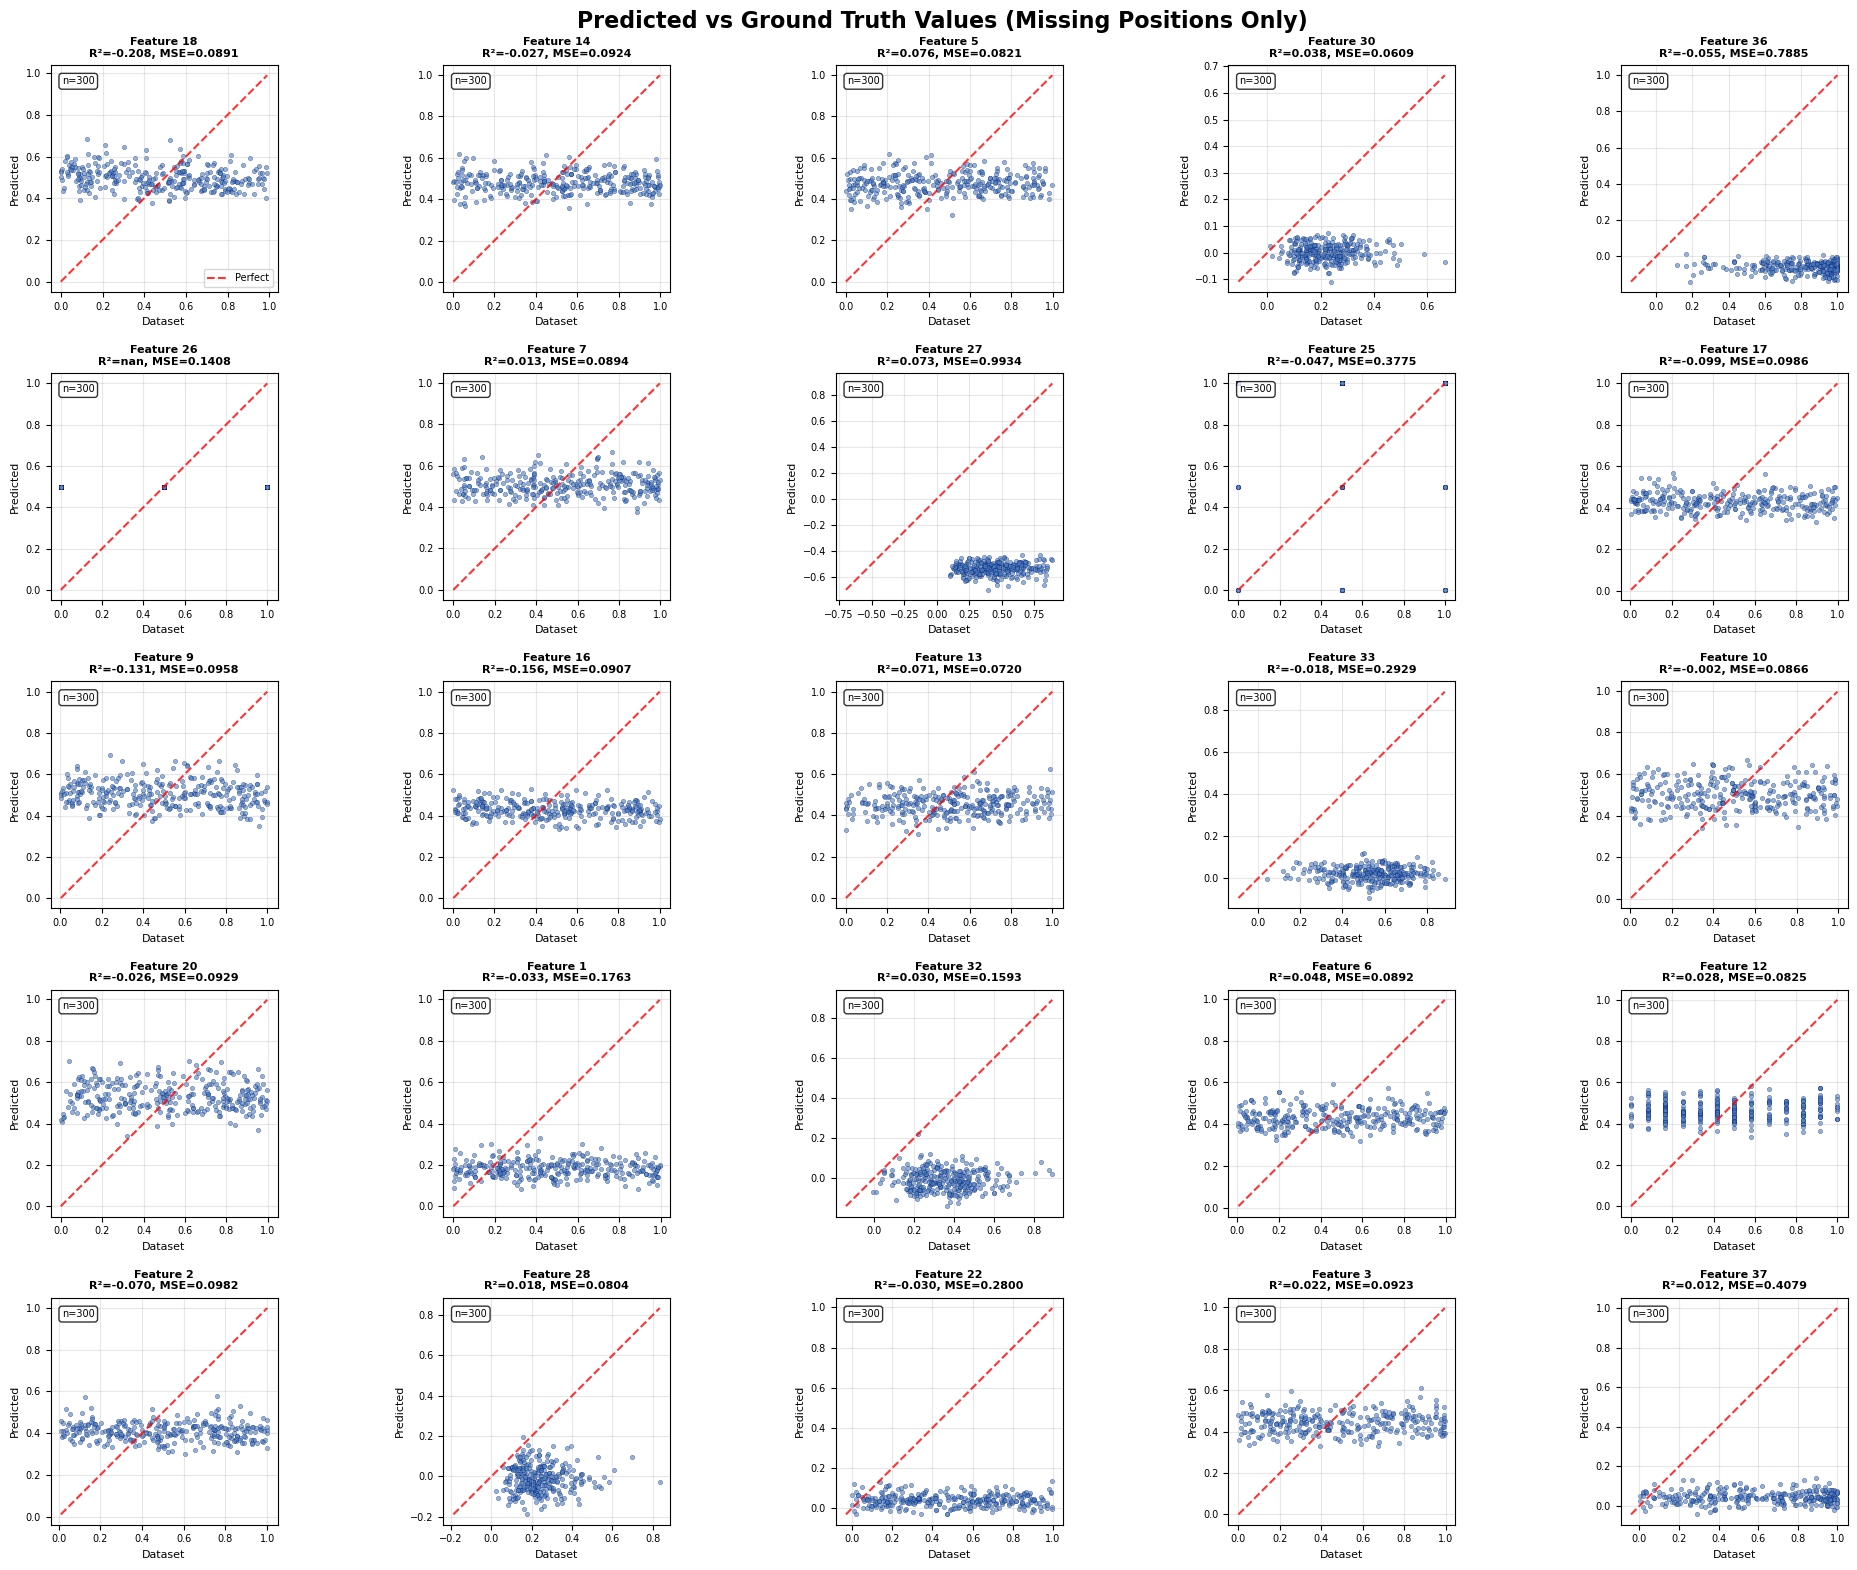

In [91]:
# Create the visualization
plot_prediction_scatter(test_imputations_denorm, test_original_denorm, test_masks, feature_names, n_features=25)



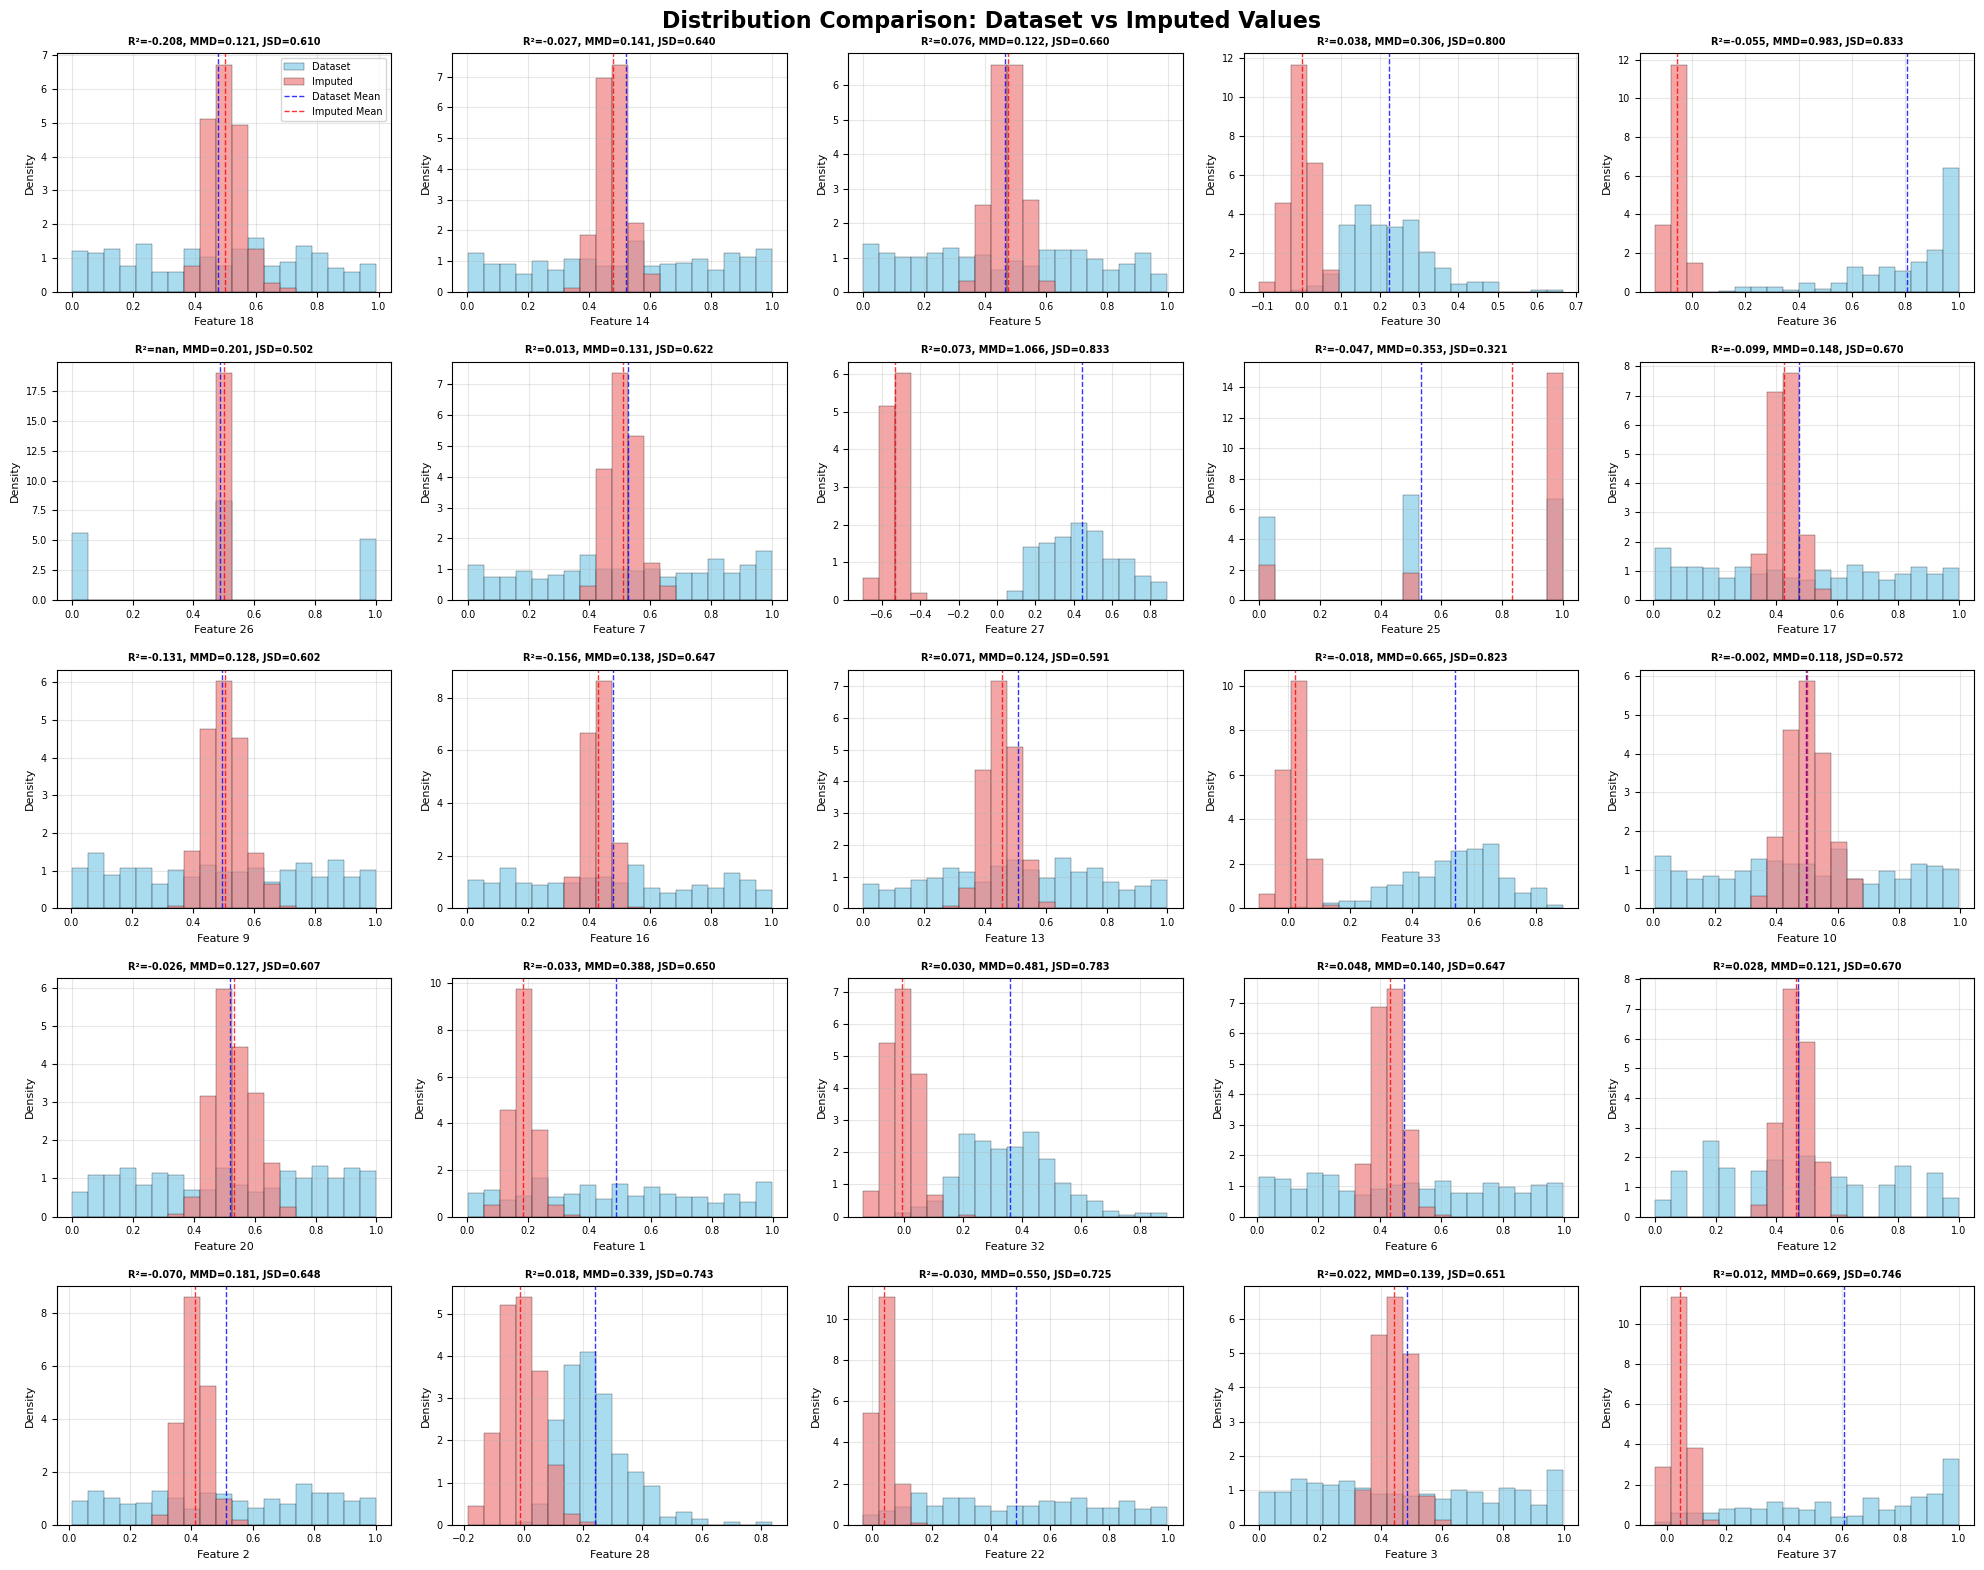

In [92]:
# Distribution comparison plots
plot_distribution_comparison(test_imputations_denorm, test_original_denorm,
                             test_masks, feature_names, n_features=25)


### Distribution Comparison Visualizations

Visual comparison of predicted vs. dataset distributions is crucial for understanding model performance beyond simple error metrics. These plots help us assess:

**What the Plots Show:**
- **Red (Imputed)**: Distribution of model's predicted values for missing positions
- **Blue (Dataset)**: Distribution of actual values at those same positions
- **Overlap**: How well the model captures the true data distribution

**Why This Matters:**
- A good generative model should not just minimize error, but also preserve the statistical properties of the data
- If distributions match well, the model is generating realistic values
- Large differences indicate the model may be systematically biased or missing important patterns

**Interpretation:**
- **Good**: Overlapping distributions with similar shapes and centers
- **Concerning**: Shifted means, different variances, or completely different shapes

In [93]:
def generate_samples(model, X_test, test_loader, device, n_samples_per_test=100):
    """Generate multiple samples for a dataset using the trained model.
    """
    # We'll generate multiple samples
    test_samples = np.zeros((X_test.shape[0], n_samples_per_test, X_test.shape[1]))

    # Set model to evaluation mode
    model.eval()

    with torch.no_grad():
        # Create a progress bar for all samples
        from tqdm import tqdm

        for batch_idx, (batch_data, batch_mask) in enumerate(tqdm(test_loader, desc="Generating Samples")):
            batch_data = batch_data.to(device)
            batch_mask = batch_mask.to(device)

            # Calculate the indices for this batch
            start_idx = batch_idx * test_loader.batch_size
            end_idx = min(start_idx + test_loader.batch_size, X_test.shape[0])
            actual_batch_size = end_idx - start_idx

            # Generate multiple samples for each item in the batch
            for j in range(n_samples_per_test):
                # Get reconstruction
                reconstruction, mu, logvar = model(batch_data, batch_mask) # TODO: Change this line based on the model you use

                # Apply mask: keep original values where available, use reconstructed values where missing
                mask_float = batch_mask.float()
                imputed = batch_data * mask_float + reconstruction * (1 - mask_float)

                # Store the samples (already in original scale since we didn't normalize)
                test_samples[start_idx:end_idx, j, :] = imputed.cpu().numpy()
    print(f"✓ Generated samples shape: {test_samples.shape}")
    print(f"  - {test_samples.shape[0]} samples")
    print(f"  - {test_samples.shape[1]} generated variations per sample")
    print(f"  - {test_samples.shape[2]} features per sample")

    # Data is already in original scale (no denormalization needed)
    test_samples_final = test_samples.copy()

    # Calculate summary statistics
    mean_across_samples = test_samples_final.mean(axis=1)  # Mean across the 100 samples

    print(f"  - Range of means: [{mean_across_samples.min():.4f}, {mean_across_samples.max():.4f}]")

    return test_samples

In [94]:
# Test Evaluation

print("="*70)
print("TEST EVALUATION")
print("="*70)

# Generate multiple samples for test using the trained model
print(f"Generating 100 samples for each of {X_test.shape[0]} test samples...")

test_samples = generate_samples(
    model, X_test, test_loader, device, n_samples_per_test=100
)

TEST EVALUATION
Generating 100 samples for each of 375 test samples...


Generating Samples:   0%|          | 0/6 [00:00<?, ?it/s]


ValueError: too many values to unpack (expected 2)

In [ ]:
test_score = compute_score(generated_samples=test_samples, set_name='test')
print("Test score:", test_score)

NameError: name 'test_samples' is not defined

The final score is computed as: Mean Correlation − Mean JS Divergence − Mean MSE

Just as we compare generated samples for the test set against the original unimputed values, we will apply the same metric to the samples you generate for test2, using the hidden test2 set. This will determine your final submission score.

## Preparing a submission:
Let's prepare a submission. We expect the final submission to be a 417x100x37 numpy array. These correspond to the 100 diverse samples you generated based on the constrained parameters we provided in the test2 set.

In [ ]:
# Test2 Evaluation

print("="*70)
print("TEST2 EVALUATION")
print("="*70)

# Generate multiple samples for test2 using the trained model
print(f"Generating 100 samples for each of {X_test2.shape[0]} test2 samples...")

test2_samples = generate_samples(
    model, X_test2, test2_loader, device, n_samples_per_test=100
)

TEST2 EVALUATION
Generating 100 samples for each of 417 test2 samples...


Generating Samples: 100%|██████████| 7/7 [00:00<00:00,  7.76it/s]

✓ Generated samples shape: (417, 100, 37)
  - 417 samples
  - 100 generated variations per sample
  - 37 features per sample
  - Range of means: [-0.0804, 1.0000]


### Test2 Evaluation: Generating Diverse Design Completions

This is the core evaluation for your AI Copilot assignment. Here we:

**Input**: Test2 samples with some known features (constraints) and some missing features (free parameters)

**Output**: 100 diverse, plausible completions for each test sample

**Why 100 Samples?**
- Engineers want to explore multiple design options, not just one "best" solution
- Diversity helps discover unexpected but valid design combinations  

**Technical Process:**
1. For each test2 sample, use the trained model to generate 100 different completions
2. Each completion respects the known constraints (observed values)
3. Missing values are filled with diverse, model-generated predictions
4. Final output: 417 × 100 × 37 array (417 test samples, 100 variants each, 37 features)

In [ ]:
id = np.random.randint(1e8, 1e9-1)
np.save(f"{id}.npy", test2_samples)

### Summary and Tips for CP3

The VAE baseline reproduces the dataset distribution well for some features, but others still show substantial discrepancies, indicating significant room for improvement!

**Key Observations:**
- **Strengths**: The model captures general feature ranges and some distributional patterns
- **Weaknesses**: Some features show systematic bias or poor distribution matching
- **Opportunities**: Advanced architectures (diffusion models, transformers) or better conditioning strategies could improve performance

**For Your Assignment**: Consider these results as a baseline. Think about:
- Which features are hardest to predict and why?
- How could you modify the architecture or training process?
- What additional constraints or domain knowledge could help?